In [1]:
from collections import Counter
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import os
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#nltk
import nltk
#nltk.download('vader_lexicon')
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams 

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

#gensim
import gensim
from gensim import corpora
from gensim import models
from gensim.models import CoherenceModel
import gensim.downloader as api
from gensim.models import LdaModel, LdaMulticore
from gensim.utils import simple_preprocess, lemmatize
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [2]:
#pip install vaderSentiment

In [3]:
import glob
path = r'Crawled_Data'                     # use your path
TA_files = glob.iglob(os.path.join(path, "*_tripadvisor.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
df_list = []
for f in TA_files:
    df_file = pd.read_csv(f)
    location = f.partition("_tripadvisor.csv")[0].partition("Crawled_Data\\")[2]
    df_file["Location"] = location
    df_list.append(df_file)
#df_from_each_file = (pd.read_csv(f) for f in TA_files)
TA_df = pd.concat(df_list, ignore_index=True)

In [4]:
#TA_df.columns
TA_df.shape

(8580, 8)

# EDA
#### Basic EDA of dataset

In [5]:
duplicate_rows_df = TA_df[TA_df.duplicated()]
print('number of duplicate rows:', duplicate_rows_df.shape)

number of duplicate rows: (2962, 8)


In [6]:
duplicateRowsDF = TA_df[TA_df.duplicated()]
print(duplicateRowsDF)

     username num_posts date_posted date_experienced  rating review_title  \
1777      NaN       NaN         NaN              NaN     NaN          NaN   
1779      NaN       NaN         NaN              NaN     NaN          NaN   
1781      NaN       NaN         NaN              NaN     NaN          NaN   
1783      NaN       NaN         NaN              NaN     NaN          NaN   
1785      NaN       NaN         NaN              NaN     NaN          NaN   
...       ...       ...         ...              ...     ...          ...   
8570      NaN       NaN         NaN              NaN     NaN          NaN   
8572      NaN       NaN         NaN              NaN     NaN          NaN   
8574      NaN       NaN         NaN              NaN     NaN          NaN   
8576      NaN       NaN         NaN              NaN     NaN          NaN   
8578      NaN       NaN         NaN              NaN     NaN          NaN   

     review_text          Location  
1777         NaN  national_gallery  
1

### EDA after dropping rows

In [7]:
TA_df = TA_df.dropna(thresh=2)
TA_df.shape

(5615, 8)

In [8]:
TA_df.isnull().values.any()
#most of the null rows is the date_experienced.

True

In [9]:
TA_df[TA_df.isnull().any(axis=1)]

username num_posts date_posted date_experienced  rating  \
880      andrewjohnporter       142    Apr 2015              NaN    30.0   
896               tom8787        52    Mar 2015              NaN    40.0   
901               golem67       648    Mar 2015              NaN    40.0   
914           havaiisteve       143    Feb 2015              NaN    40.0   
924   GlobeTrotting562042         7    Feb 2015              NaN    50.0   
...                   ...       ...         ...              ...     ...   
8531           Monster695        52      Feb-12              NaN    40.0   
8533             Melvin S        25      Feb-12              NaN    40.0   
8541              robfbme        11      Jan-12              NaN    30.0   
8577           HappyBelly       391      Aug-10              NaN    40.0   
8579               Sara L         6      Mar-09              NaN    50.0   

                                           review_title  \
880                                         Ok but free   
896                                         Educational   
901                                    Enjoyable visit!   
914                                          Excellent    
924   Amazing and interesting !!! Now it's free entr...   
...                                                 ...   
8531  Second best place in Singapore to view Wu Guan...   
8533  Old Schoolhouse given a new lease of life - ar...   
8541                  more modern than you might expect   
8577                               pleasantly surprised   
8579                  Surprises Await at the Art Museum   

                                            review_text  \
880   Renovations are taking place so only certain s...   
896   Pretty extensive museums for the history buffs...   
901   Worth the visit, the artistic Koran was intere...   
914   About half the exhibits were closed due to ren...   
924   I planed to spend in this museum one hour. Fin...   
...                                                 ...   
8531  Wander to the neighbouring art galleries to se...   
8533  I'm not an art buff and many of the exhibits i...   
8541  I am a member of this museum and enjoy art, ho...   
8577  This is not the Louvre, but there were times w...   
8579  My husband and I were not planning on the visi...   

                        Location  
880   asian_civilization_musueum  
896   asian_civilization_musueum  
901   asian_civilization_musueum  
914   asian_civilization_musueum  
924   asian_civilization_musueum  
...                          ...  
8531              sg_art_musueum  
8533              sg_art_musueum  
8541              sg_art_musueum  
8577              sg_art_musueum  
8579              sg_art_musueum  

[131 rows x 8 columns]

In [10]:
TA_df.isna().sum()

username              0
num_posts             0
date_posted           0
date_experienced    130
rating                0
review_title          1
review_text           0
Location              0
dtype: int64

### Number of reviews for each musuem

In [11]:
test_df = TA_df.groupby(["Location"]) \
            .agg({"Location" : pd.Series.count}) \
            .rename(columns = {"Location": "Num_Reviews"}) \
            .sort_values("Num_Reviews", ascending = False)
test_df.head()

Num_Reviews
Location                               
asian_civilization_musueum         1775
national_musueum                   1545
national_gallery                   1025
peranakan_musueum                   875
sg_art_musueum                      395

In [12]:
TA_df.sample(10)

username num_posts date_posted date_experienced  rating  \
5332  NauticalDreamer3010       512      Jul-17           Jun-17    40.0   
7251                 SY S        26    Jan 2016     January 2016    40.0   
1022             Pjkm1954        14    Oct 2014     October 2014    40.0   
2998             Thiago T         9      Feb-17           Feb-17    50.0   
3796             Choo Wai     1,872      Dec-15           Nov-15    40.0   
8039            jiffy2006       466      Jan-16           Jan-16    30.0   
5884      robert_and_anne        55      Oct-16           Oct-16    50.0   
5764                  Jac        88      Dec-16           Oct-16    40.0   
3012        AliceAlice194        23      Feb-17           Jan-17    40.0   
6084      Ava Tar Govin R         6      Jul-16           Feb-16    50.0   

                                          review_title  \
5332            A must for those interested in history   
7251  A better understanding of Peranakan culture here   
1022                                   Pick of museums   
2998                         Top of the list for Arts!   
3796     Everyone will find their own favorite pieces!   
8039               Nothing special but it's early days   
5884                     Once upon a time in Singapore   
5764                               Worthwhile to visit   
3012                  Great place to spend the morning   
6084                               Educational and fun   

                                            review_text  \
5332  We only spent a couple of hours here and manag...   
7251  In this museum, you will be able to understand...   
1022  Very good exhibits. Muslim exhibit was closed....   
2998  One of my favourite spots in SG. A brilliant c...   
3796  There were lots of awesome mind-blowing art pi...   
8039  What a wonderful building to preserve.<br/>Fri...   
5884  The museum consists of two parts, which you ca...   
5764  It was a rainy day and therefore the best choi...   
3012  My daughter and I popped into the Ar Gallery o...   
6084  It will be eductional and they have fun things...   

                        Location  
5332            national_musueum  
7251           peranakan_musueum  
1022  asian_civilization_musueum  
2998            national_gallery  
3796            national_gallery  
8039              sg_art_musueum  
5884            national_musueum  
5764            national_musueum  
3012            national_gallery  
6084            national_musueum

In [13]:
#!pip install spacy && python -m spacy download en

In [14]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

# Start of processing and Aspect Based Opinion Mining
### Get length/word_count of reviews and polarity of review using textblob

In [15]:
review_df = TA_df.copy()
review_df = review_df.drop(columns = ["username", "num_posts", "date_posted", "date_experienced"])
review_df['review_text'] = preprocess(review_df['review_text'])
review_df['polarity'] = review_df['review_text'].map(lambda text: TextBlob(text).sentiment.polarity)
review_df['review_len'] = review_df['review_text'].astype(str).apply(len)
review_df['word_count'] = review_df['review_text'].apply(lambda x: len(str(x).split()))
review_df.head()

rating                                   review_title  \
0    40.0            Interesting way to view all of Asia   
1    50.0     Place is very interesting with exhibitions   
2    40.0                           Always worth a visit   
3    50.0  (Min) 2 hours are recommended for this place!   
4    40.0                             Interesting Museum   

                                         review_text  \
0  I spent a nice Sunday morning here. I enjoyed ...   
1  Interesting place with many exhibitions, great...   
2  We've been to singapore many times and always ...   
3  The Asian Civilisations Museum is meant to sho...   
4  I spent a couple of hours exploring this museu...   

                     Location  polarity  review_len  word_count  
0  asian_civilization_musueum  0.300000         215          40  
1  asian_civilization_musueum  0.575000         116          18  
2  asian_civilization_musueum  0.616667         196          33  
3  asian_civilization_musueum  0.252083         707         118  
4  asian_civilization_musueum  0.381250         367          67

### EDA of Results

In [16]:
review_df.describe()

rating     polarity    review_len   word_count
count  5615.000000  5615.000000   5615.000000  5615.000000
mean     43.948353     0.296856    382.486020    66.234016
std       8.122295     0.176855    374.303802    64.171926
min      10.000000    -0.750000     51.000000     7.000000
25%      40.000000     0.183333    181.000000    31.000000
50%      50.000000     0.287500    283.000000    49.000000
75%      50.000000     0.400000    451.000000    79.000000
max      50.000000     1.000000  12341.000000  2037.000000

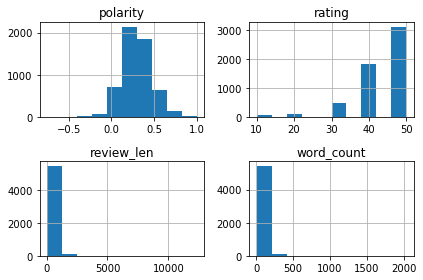

In [17]:
(review_df.hist())
plt.tight_layout()
#don't need to normalize here because the model takes care of the skewness

### Sample of good/neutral/bad reviews

In [18]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = review_df.loc[review_df.polarity == 1, ['review_text']].sample(5).values
for c in cl:
    print(c[0] + "\n")

5 random reviews with the highest positive sentiment polarity: 

We still think this is one of the best museums in all of Asia, a nose ahead to the National Museum in Taipei.  Put in on your must see list.

Wonderful section for children in the keppel centre. Lots of interactive items , and the opportunity for children to become involve in art activities

It's the best place to study the history of Singapore. They simulate the rain forest electronically.

range of works is staggering, curation and information excellent, media orientation one of the best parts, exhibition not too crowded, all the pieces of interest and quality

The building is awesome and beautifully retrofitted. However, there is insufficient display of artwork!



In [19]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = review_df.loc[review_df.polarity == 0, ['review_text']].sample(5).values
for c in cl:
    print(c[0] + "\n")

5 random reviews with the most neutral sentiment(zero) polarity: 

A place to learn about the peranakan history. You can see about their wedding stuff,  their costum, and all about peranakan history.

This is your chance to see and readup on asian history and see how it fits into this area. There is a lot to see and at the moment there is an expeition on a ship wreak and some of what it caotained.

musuem did not meet my expectations.  I still did not follow the history of singapore even after viewing.

The family decided to take a tour of the museum. Pretty small set up and could definitely be improved in terms of the layout of the exhibits.

Besides a room of Singapore's (recent) past, there are quite a lot of south-east asian artifacts on display. A visit here is educational. Kudos to those who set up this museum.



In [20]:
print('5 reviews with the most negative polarity: \n')
cl = review_df.loc[review_df.polarity < -0.30, ['review_text']].sample(5).values
for c in cl:
    print(c[0] + "\n")

5 reviews with the most negative polarity: 

My friend and I went to visit this gallery.  My friend who was visiting from Scotland was very shocked at how expensive it was to get in.  She is used to gallery's being free in the UK.It was $20 to get in. My friend didn't want to pay that so we didn't go in.

It's like going to the Colosseum, only to find the contents of the Louvre being dumped into it, in a badly patched up interior. You have trivialized what the two buildings meant to Singapore's history

Very small museum with a very small collection on exhibition

I went to visit the Singapore exhibition and learned a lot about Sg history. must visit at least once!

As with a lot of stuff in Singapore, you end up walking loads - between 2 buildings and 5 floors. However art is so thinly spread out, it really is very sparse when looked at. Very disappointed and not worth the fee for foreigners when you see what else is around.



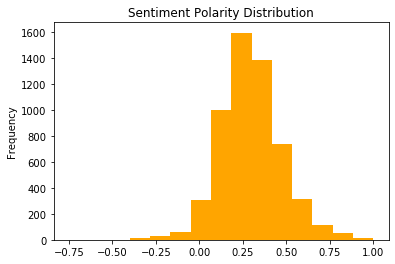

In [21]:
review_df['polarity'].plot(
    kind='hist',
    bins=15,
    color = "orange",
    title='Sentiment Polarity Distribution')

### Analysis of n-grams w/w.o removing stopwords

In [22]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(review_df['review_text'], 20)
# for word, freq in common_words:
#     print(word, freq)

print('Top 20 words in review before removing stop words (unigram)')
df1 = pd.DataFrame(common_words, columns = ['review_text' , 'count'])
df1.groupby('review_text').sum()['count'].sort_values(ascending=False)


Top 20 words in review before removing stop words (unigram)


review_text
the          24338
and          12946
of           10634
to           10299
is            6438
in            5608
museum        4955
it            4812
singapore     3974
was           3795
for           3565
this          3530
you           3515
are           2737
on            2699
there         2604
we            2566
with          2418
very          2371
that          2365
Name: count, dtype: int64

In [23]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(review_df['review_text'], 20)
# for word, freq in common_words:
#     print(word, freq)
print('Top 20 words in review after removing stop words (unigram)')
df2 = pd.DataFrame(common_words, columns = ['review_text' , 'count'])
df2.groupby('review_text').sum()['count'].sort_values(ascending=False)

Top 20 words in review after removing stop words (unigram)


review_text
museum         4955
singapore      3974
history        2331
visit          1981
art            1734
building       1510
interesting    1422
exhibits       1339
time           1306
place          1305
gallery        1251
great          1242
good           1224
worth          1057
free            960
tour            915
exhibition      908
asian           901
hours           846
peranakan       823
Name: count, dtype: int64

In [24]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(review_df['review_text'], 20)
# for word, freq in common_words:
#     print(word, freq)

print('Top 20 bigrams in review before removing stop words')
df3 = pd.DataFrame(common_words, columns = ['review_text' , 'count'])
df3.groupby('review_text').sum()['count'].sort_values(ascending=False)

Top 20 bigrams in review before removing stop words


review_text
of the          3047
the museum      1707
of singapore    1301
in the          1286
to the          1155
and the         1078
if you          1013
it is            962
this museum      962
history of       880
the history      833
on the           811
museum is        775
to see           770
it was           765
in singapore     758
from the         663
at the           651
this is          648
there is         635
Name: count, dtype: int64

In [25]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(review_df['review_text'], 20)
# for word, freq in common_words:
#     print(word, freq)
print('Top 20 bigrams in review after removing stop words')
df4 = pd.DataFrame(common_words, columns = ['review_text' , 'count'])
df4.groupby('review_text').sum()['count'].sort_values(ascending=False)

Top 20 bigrams in review after removing stop words


review_text
history singapore    554
worth visit          409
singapore history    340
national gallery     335
national museum      306
supreme court        289
guided tour          288
city hall            267
museum singapore     206
south east           197
peranakan culture    166
visit museum         156
art museum           152
great place          143
spent hours          142
peranakan museum     137
east asia            134
asian art            134
couple hours         128
spend hours          122
Name: count, dtype: int64

In [26]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(review_df['review_text'], 20)
# for word, freq in common_words:
#     print(word, freq)
print('Top 20 trigrams in review before removing stop words')
df5 = pd.DataFrame(common_words, columns = ['review_text' , 'count'])
df5.groupby('review_text').sum()['count'].sort_values(ascending=False)

Top 20 trigrams in review before removing stop words


review_text
the history of          634
history of singapore    530
the museum is           355
one of the              301
if you are              279
of the museum           240
this museum is          236
some of the             222
the national gallery    220
the national museum     213
about the history       180
to see the              179
history of the          174
as well as              174
of singapore and        147
the building itself     147
well worth visit        135
if you have             130
to learn about          128
if you want             125
Name: count, dtype: int64

In [27]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(review_df['review_text'], 20)
# for word, freq in common_words:
#     print(word, freq)
print('Top 20 trigrams in review after removing stop words')
df6 = pd.DataFrame(common_words, columns = ['review_text' , 'count'])
df6.groupby('review_text').sum()['count'].sort_values(ascending=False)

Top 20 trigrams in review after removing stop words


review_text
south east asia               122
national museum singapore     110
national gallery singapore    100
asian civilisations museum     84
singapore art museum           74
old supreme court              73
south east asian               72
court city hall                66
hall supreme court             63
city hall supreme              62
supreme court city             62
free guided tour               60
definitely worth visit         59
free guided tours              45
supreme court building         41
lee kuan yew                   41
city hall mrt                  39
museum worth visit             37
learn history singapore        35
old city hall                  34
Name: count, dtype: int64

#### Before Removing Stopwords

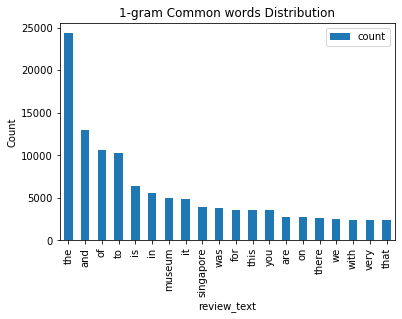

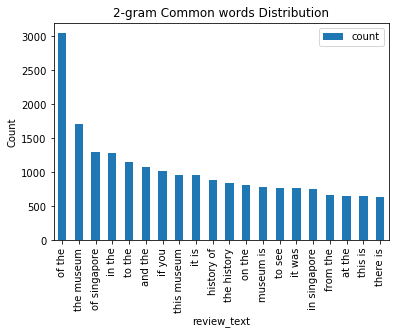

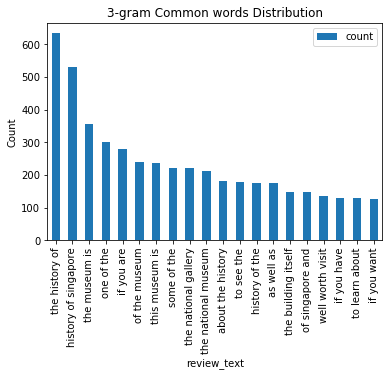

In [28]:
def get_top_n_gram(corpus,a,n=None):
    vec = CountVectorizer(ngram_range=(a,a)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for i in range(1,4):
    common_words = get_top_n_gram(review_df['review_text'],i,20)
    df_commonwords = pd.DataFrame(common_words, columns = ['review_text' , 'count'])

    ax = df_commonwords.plot(
        kind='bar',
        x = 'review_text',
        y = 'count',
        title=str(i)+'-gram Common words Distribution')
    ax.set_ylabel("Count")
    plt.show()

#### After Removing Stopwords

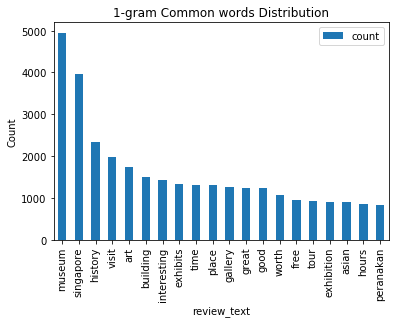

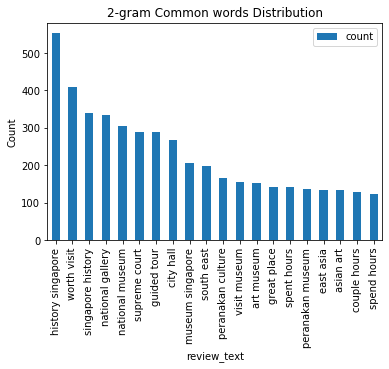

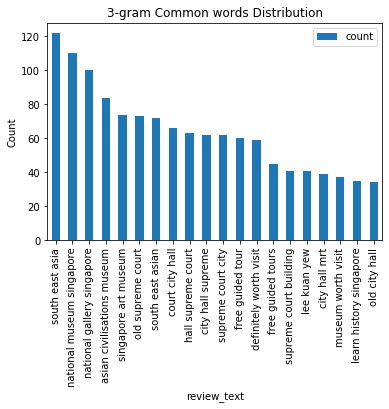

In [29]:
def get_top_n_gram(corpus,a,n=None):
    vec = CountVectorizer(ngram_range=(a,a), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for i in range(1,4):
    common_words = get_top_n_gram(review_df['review_text'],i,20)
    df_commonwords = pd.DataFrame(common_words, columns = ['review_text' , 'count'])

    ax = df_commonwords.plot(
        kind='bar',
        x = 'review_text',
        y = 'count',
        title=str(i)+'-gram Common words Distribution')
    ax.set_ylabel("Count")
    plt.show()

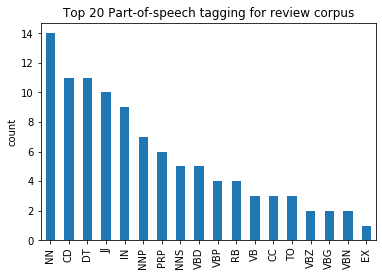

In [30]:
#blob = TextBlob(str(review_df['review_text']))
from textblob.taggers import NLTKTagger
nltk_tagger = NLTKTagger()
blob = TextBlob(str(review_df["review_text"]), pos_tagger=nltk_tagger)
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()
ax = pos_df.plot(
    kind='bar',
    x = 'pos',
    y = 'count',
    title='Top 20 Part-of-speech tagging for review corpus')
ax.set_ylabel("count")
plt.show()



# Creating a way to analyze the reviews from diff places
#### NLP / KERAS ASPECT BASED OPINION MINING APPROACH - Need training data, so not going to do, but going to use the aspect terms/sentiments approach from it

In [31]:
nlp = spacy.load('en_core_web_sm')

review_df["review_text"] = review_df.review_text.str.lower()

aspect_terms = []
for review in nlp.pipe(review_df.review_text):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
review_df['aspect_terms'] = aspect_terms
#review_df.head()

In [32]:
sentiment_terms = []
for review in nlp.pipe(review_df['review_text']):
        if review.is_parsed:
            sentiment_terms.append(' '.join([token.lemma_ for token in review if (not token.is_stop and not token.is_punct and (token.pos_ == "ADJ" or token.pos_ == "VERB"))]))
        else:
            sentiment_terms.append('')  
review_df['sentiment_terms'] = sentiment_terms
#review_df.head(10)

In [33]:
review_df.head()

rating                                   review_title  \
0    40.0            Interesting way to view all of Asia   
1    50.0     Place is very interesting with exhibitions   
2    40.0                           Always worth a visit   
3    50.0  (Min) 2 hours are recommended for this place!   
4    40.0                             Interesting Museum   

                                         review_text  \
0  i spent a nice sunday morning here. i enjoyed ...   
1  interesting place with many exhibitions, great...   
2  we've been to singapore many times and always ...   
3  the asian civilisations museum is meant to sho...   
4  i spent a couple of hours exploring this museu...   

                     Location  polarity  review_len  word_count  \
0  asian_civilization_musueum  0.300000         215          40   
1  asian_civilization_musueum  0.575000         116          18   
2  asian_civilization_musueum  0.616667         196          33   
3  asian_civilization_musueum  0.252083         707         118   
4  asian_civilization_musueum  0.381250         367          67   

                                        aspect_terms  \
0  morning bowls boxes figurines pictures way cou...   
1             place exhibitions photos people photos   
2      exhibit finds shipwreck highlight trip friend   
3  art culture building presence exhibit cargo sh...   
4  couple hours museum wreck items ship quantity ...   

                                     sentiment_terms  
0       spend nice enjoy enjoy present affect entire  
1                        interesting great take come  
2                  singapore drop preserve recommend  
3  mean showcase rich lovely strong recover sink ...  
4  spend explore start find interesting pack pack...

### Aggregating the metrics by Location

In [34]:
review_df.groupby('Location').mean()

rating  polarity  review_len  word_count
Location                                                               
asian_civilization_musueum  44.253521  0.300871  327.008451   56.535211
national_gallery            44.165854  0.292638  502.366829   87.410732
national_musueum            44.640777  0.308285  359.888673   62.363754
peranakan_musueum           44.194286  0.300472  370.474286   63.169143
sg_art_musueum              38.759494  0.237048  435.696203   76.792405

# Finding out which are the aspects that led to the most positive/negative reviews

### Create own weighted scoring system 
--> Rated based on 3 Factors
1. Rating [between 10 to 50] -> (50%) 
2. Polarity [between -0.75 to 1.00 ] -> (35%)
3. Word_Count [between 7 to 2037] -> (15%)

In [35]:
def get_weighted_score(rating,polarity,w_pct_rank):
    if polarity < 0:
        if rating <= 20:
            weighted_score = -(rating/50) * 0.5 + polarity * 0.35 - w_pct_rank * 0.15
        else:
            weighted_score = (rating/50) * 0.5 + polarity * 0.35 - w_pct_rank *0.15 #max score is 1
    else:
        weighted_score = (rating/50) * 0.5 + polarity * 0.35 + w_pct_rank *0.15 #max score is 1
    return weighted_score

def classify_score(weighted_score):
    if weighted_score < 0:
        return "bad"
    elif weighted_score > 0.6:
        return "good"
    else:
        return "ok"

In [36]:
# review_df['r_pct_rank'] = review_df['rating'].rank(pct=True)
# review_df['p_pct_rank'] = review_df['polarity'].rank(pct=True)
review_df['w_pct_rank'] = review_df['word_count'].rank(pct=True)
#review_df.drop(columns = ['r_pct_rank', 'p_pct_rank', 'w_pct_rank' ])

In [37]:
review_df['weighted_score'] = np.vectorize(get_weighted_score)(review_df['rating'],
                                                               review_df['polarity'], 
                                                               review_df['w_pct_rank'])

In [38]:
# review_df['weighted_score'] = review_df.apply(get_weighted_score, 
#                                               rating = review_df['rating'],
#                                               polarity = review_df['polarity'], 
#                                               w_pct_rank = review_df['w_pct_rank'])

In [39]:
#review_df = review_df.drop(columns = ['r_pct_rank', 'p_pct_rank'])

In [40]:
review_df.sample(5)

rating                                       review_title  \
7678    30.0            A very good short journey on Peranakan.   
7239    50.0                         A must visit in Singapore.   
3632    50.0                                      Amazing Place   
825     50.0                           Impressive and beautiful   
6542    50.0  The building is very nice, the collections are...   

                                            review_text  \
7678  do you know peranakan?it's worth a visit to pe...   
7239  this is a very interesting collection of peran...   
3632  plenty of things to see and the building itsel...   
825   if you have time and have a rainy day and no o...   
6542  if you have already found my small comments us...   

                        Location  polarity  review_len  word_count  \
7678           peranakan_musueum  0.260000         369          63   
7239           peranakan_musueum  0.458333         357          56   
3632            national_gallery  0.330000         158          30   
825   asian_civilization_musueum  0.537500         207          37   
6542            national_musueum  0.165625         402          69   

                                           aspect_terms  \
7678  order culture group museum students outing fri...   
7239  collection culture society displays building c...   
3632                plenty things building look insider   
825                time day building history collection   
6542  comments ones days city mind museum museum jac...   

                                        sentiment_terms  w_pct_rank  \
7678     know worth understand young mean primary reach    0.647017   
7239  interesting fade modern rich present restore p...    0.577293   
3632                          iconic recommend national    0.225557   
825   rainy outdoor worth keep iterinary beautiful h...    0.337845   
6542  find small usefull hope will miss link singapo...    0.688246   

      weighted_score  
7678        0.488053  
7239        0.747011  
3632        0.649333  
825         0.738802  
6542        0.661206

In [41]:
review_df.weighted_score.describe()

count    5615.000000
mean        0.612178
std         0.141015
min        -0.406645
25%         0.559262
50%         0.635843
75%         0.702611
max         0.885638
Name: weighted_score, dtype: float64

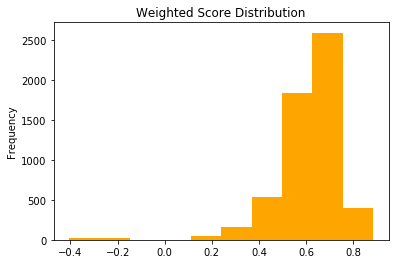

In [42]:
review_df['weighted_score'].plot(
    kind='hist',
    bins=10,
    color = "orange",
    title='Weighted Score Distribution')

# Classify weighted scores into 3 classes - Bad, Ok, Good

## EDA of Results

In [43]:
review_df['class'] = review_df['weighted_score'].apply(classify_score)

In [44]:
review_df['class'].value_counts()

good    3559
ok      2009
bad       47
Name: class, dtype: int64

In [45]:
review_df.loc[review_df['class'] == "good"].sample(5)

rating                                review_title  \
7361    50.0  Beautiful &amp; beautifully curated museum   
4116    40.0             Free guided tour was excellent!   
1290    50.0                                 Fascinating   
1729    50.0                                     awesome   
41      50.0                           Must visit place!   

                                            review_text  \
7361  the peranakan museum is one of the more intere...   
4116  we did a free guided tour of the museum with a...   
1290  the exhibits were very well displayed and inte...   
1729  superbly presented exhibits, special features ...   
41    there are not many museums that focus on asian...   

                        Location  polarity  review_len  word_count  \
7361           peranakan_musueum  0.400000         906         148   
4116            national_musueum  0.353125         343          64   
1290  asian_civilization_musueum  0.362500         203          36   
1729  asian_civilization_musueum  0.619048         151          24   
41    asian_civilization_musueum  0.100000         350          67   

                                           aspect_terms  \
7361  museums terms exhibitions museum part structur...   
4116  tour museum guide guide questions tour history...   
1290                             exhibits culture items   
1729        exhibits features people topic myriad offer   
41    museums civilizations place lot hours tour caf...   

                                        sentiment_terms  w_pct_rank  \
7361  interesting visit strive maintain original res...    0.930632   
4116  free guide knowledgeable answer take interesti...    0.656723   
1290  display interesting nice cool think primitive ...    0.321906   
1729               present special change find interest    0.122529   
41    focus asian make visit expect spend free docen...    0.674978   

      weighted_score class  
7361        0.779595  good  
4116        0.622102  good  
1290        0.675161  good  
1729        0.735046  good  
41          0.636247  good

In [86]:
pd.options.display.max_colwidth = 500
review_df.nlargest(5, columns=['weighted_score'])

rating                                    review_title  \
4980    50.0  Brilliant museum that is a credit to Singapore   
702     50.0                     Our second vista in 8 years   
1355    50.0            one of the best museums in the world   
508     50.0                        A place for museum geeks   
18      50.0                            Well worth the visit   

                                                                                                                                                                                                                                                                                                              review_text  \
4980  this is one of best museums that i have visited. it is well laid out in a beautiful building that is so easy to get to. the staff are incredibly helpful. if you like history and learning about singapore, it’s people and how the nation was shaped, this is the place for you. they have a wonderful app as well   
702                                                                                                                                                                          we still think this is one of the best museums in all of asia, a nose ahead to the national museum in taipei.  put in on your must see list.   
1355                                                                                                                                        range of works is staggering, curation and information excellent, media orientation one of the best parts, exhibition not too crowded, all the pieces of interest and quality   
508                                                                                       am seriously impressed by the exhibitions there were when i visited. 'christianity in south east asia' exhibition was spoilt with relics and artifacts. makes you want to stay there and appreciate the beautiful works of art.   
18                                                                                                                                                                 lots to see without being overwhelmed. the galleries were well designed and displayed. we learnt a lot and were really impressed with the collections.   

                        Location  polarity  review_len  word_count  \
4980            national_musueum  0.836667         307          60   
702   asian_civilization_musueum  1.000000         140          30   
1355  asian_civilization_musueum  1.000000         173          27   
508   asian_civilization_musueum  0.925000         223          36   
18    asian_civilization_musueum  1.000000         150          24   

                                                          aspect_terms  \
4980            museums building staff history people nation place app   
702                                                  museums nose list   
1355  range works orientation parts exhibition pieces interest quality   
508                  exhibitions exhibition relics artifacts works art   
18                                      lots galleries lot collections   

                                                       sentiment_terms  \
4980  good visit lay beautiful easy helpful like learn shape wonderful   
702                                                         think good   
1355                                           staggering good crowded   
508           impress visit spoilt make want stay appreciate beautiful   
18                            overwhelm design display learn impressed   

      w_pct_rank  weighted_score class  
4980    0.618700        0.885638  good  
702     0.225557        0.883833  good  
1355    0.174443        0.876167  good  
508     0.321906        0.872036  good  
18      0.122529        0.868379  good

In [46]:
review_df.loc[review_df['class'] == "ok"].sample(5)

rating                                       review_title  \
7549    50.0                                    Full immersion!   
4662    30.0                                 Beautiful building   
7129    30.0  Good for people interested in fabrics, clothin...   
808     20.0                               Not much of a museum   
817     40.0                                      Worth a Visit   

                                            review_text  \
7549  this should be your first stop in singapore if...   
4662  the museum is smaller than i expected but it i...   
7129  we grabbed a couple of hours in this museum. t...   
808   after reading all the reviews i decided to see...   
817   the museum is worth a visit, it was very inter...   

                        Location  polarity  review_len  word_count  \
7549           peranakan_musueum -0.060000         358          69   
4662            national_musueum  0.236111         139          24   
7129           peranakan_musueum  0.193860         943         153   
808   asian_civilization_musueum  0.085714         391          74   
817   asian_civilization_musueum  0.070000         194          39   

                                           aspect_terms  \
7549  stop culture experience travel past eyes entra...   
4662                                 museum space rooms   
7129  couple hours museum displays displays lot embr...   
808   reviews museum husband hours minutes museums p...   
817                      museum parts museum renovation   

                                        sentiment_terms  w_pct_rank  \
7549      want learn local look different need visit go    0.688246   
4662             small expect beautiful enjoy different    0.122529   
7129  grab low historical mixed cultural interesting...    0.936509   
808   read decide think disappointing finish see thi...    0.723954   
817                        worth interesting close like    0.368566   

      weighted_score class  
7549        0.375763    ok  
4662        0.401018    ok  
7129        0.508327    ok  
808         0.338593    ok  
817         0.479785    ok

In [47]:
review_df.loc[review_df['class'] == "bad"].sample(5)

rating                               review_title  \
7191    20.0                                Too crowded   
8301    10.0                          Very disappointed   
3826    10.0                             Very bad staff   
7382    20.0        Many exhibits were in bad condition   
4734    20.0  Inaccurate account of Japanese occupation   

                                            review_text           Location  \
7191  i really wanted to see this museum but it was ...  peranakan_musueum   
8301  did not find any part of this museum worth see...     sg_art_musueum   
3826  very rude, principled staff at the box office,...   national_musueum   
7382  paid $6 each adult only to be disappointed by ...  peranakan_musueum   
4734  i was very disappointed in the exhibition cove...   national_musueum   

      polarity  review_len  word_count  \
7191 -0.170000         221          40   
8301 -0.082738         444          81   
3826 -0.292656         167          34   
7382 -0.035714         274          52   
4734 -0.153571         875         147   

                                           aspect_terms  \
7191  museum groups way exhibits mouse children minutes   
8301  part museum lot walls room artwork lift 30mins...   
3826     staff office o’clock woman desk o’clock ticket   
7382  exhibits order staff peranakan part history la...   
4734  exhibition history section occupation exhibiti...   

                                        sentiment_terms  w_pct_rank  \
7191             want pack distract leave disappointing    0.383081   
8301  find worth see entire close uninspire get lose...    0.763580   
3826       rude principle arrive tell close refuse sell    0.292965   
7382  pay disappoint interactive ask tell spoilt sad...    0.531968   
4734  disappointed cover particular cover japanese g...    0.929653   

      weighted_score class  
7191       -0.316962   bad  
8301       -0.243495   bad  
3826       -0.246374   bad  
7382       -0.292295   bad  
4734       -0.393198   bad

In [102]:
good_terms = review_df.loc[review_df['class'] == "good"].aspect_terms
good_sentiments = review_df.loc[review_df['class'] == "good"].sentiment_terms
ok_terms = review_df.loc[review_df['class'] == "ok"].aspect_terms
bad_terms = review_df.loc[review_df['class'] == "bad"].aspect_terms

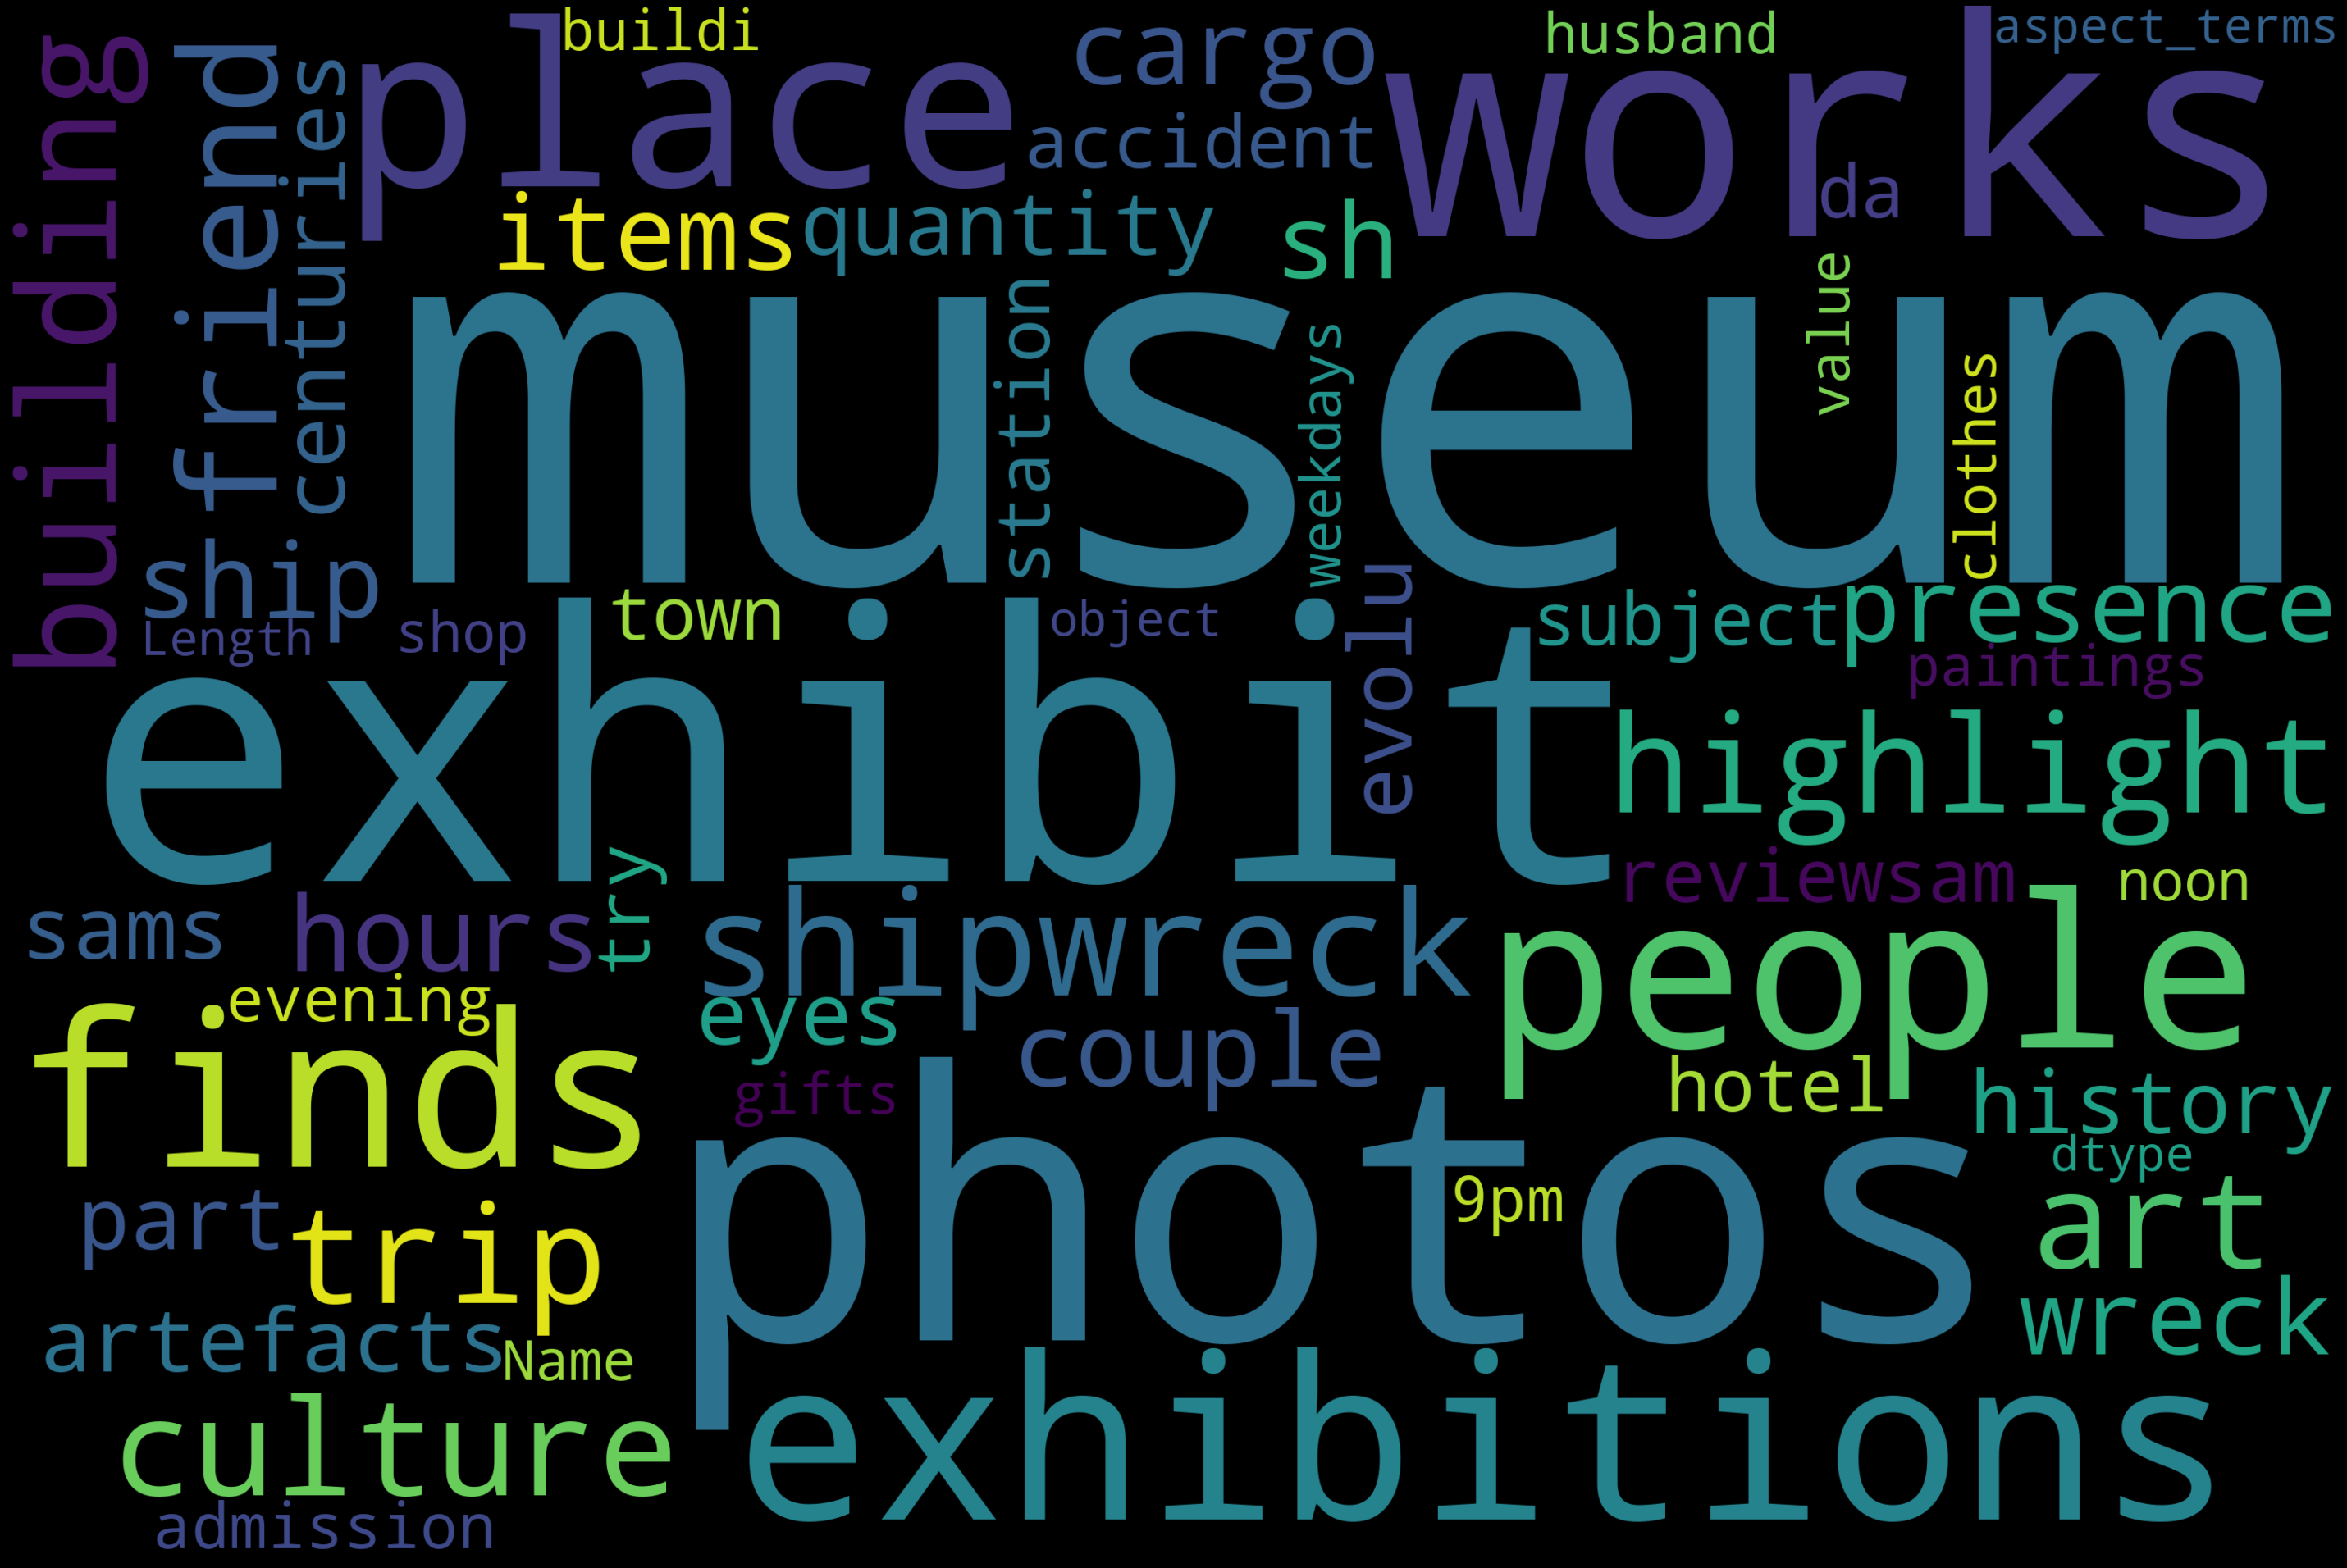

In [49]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = good_terms
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

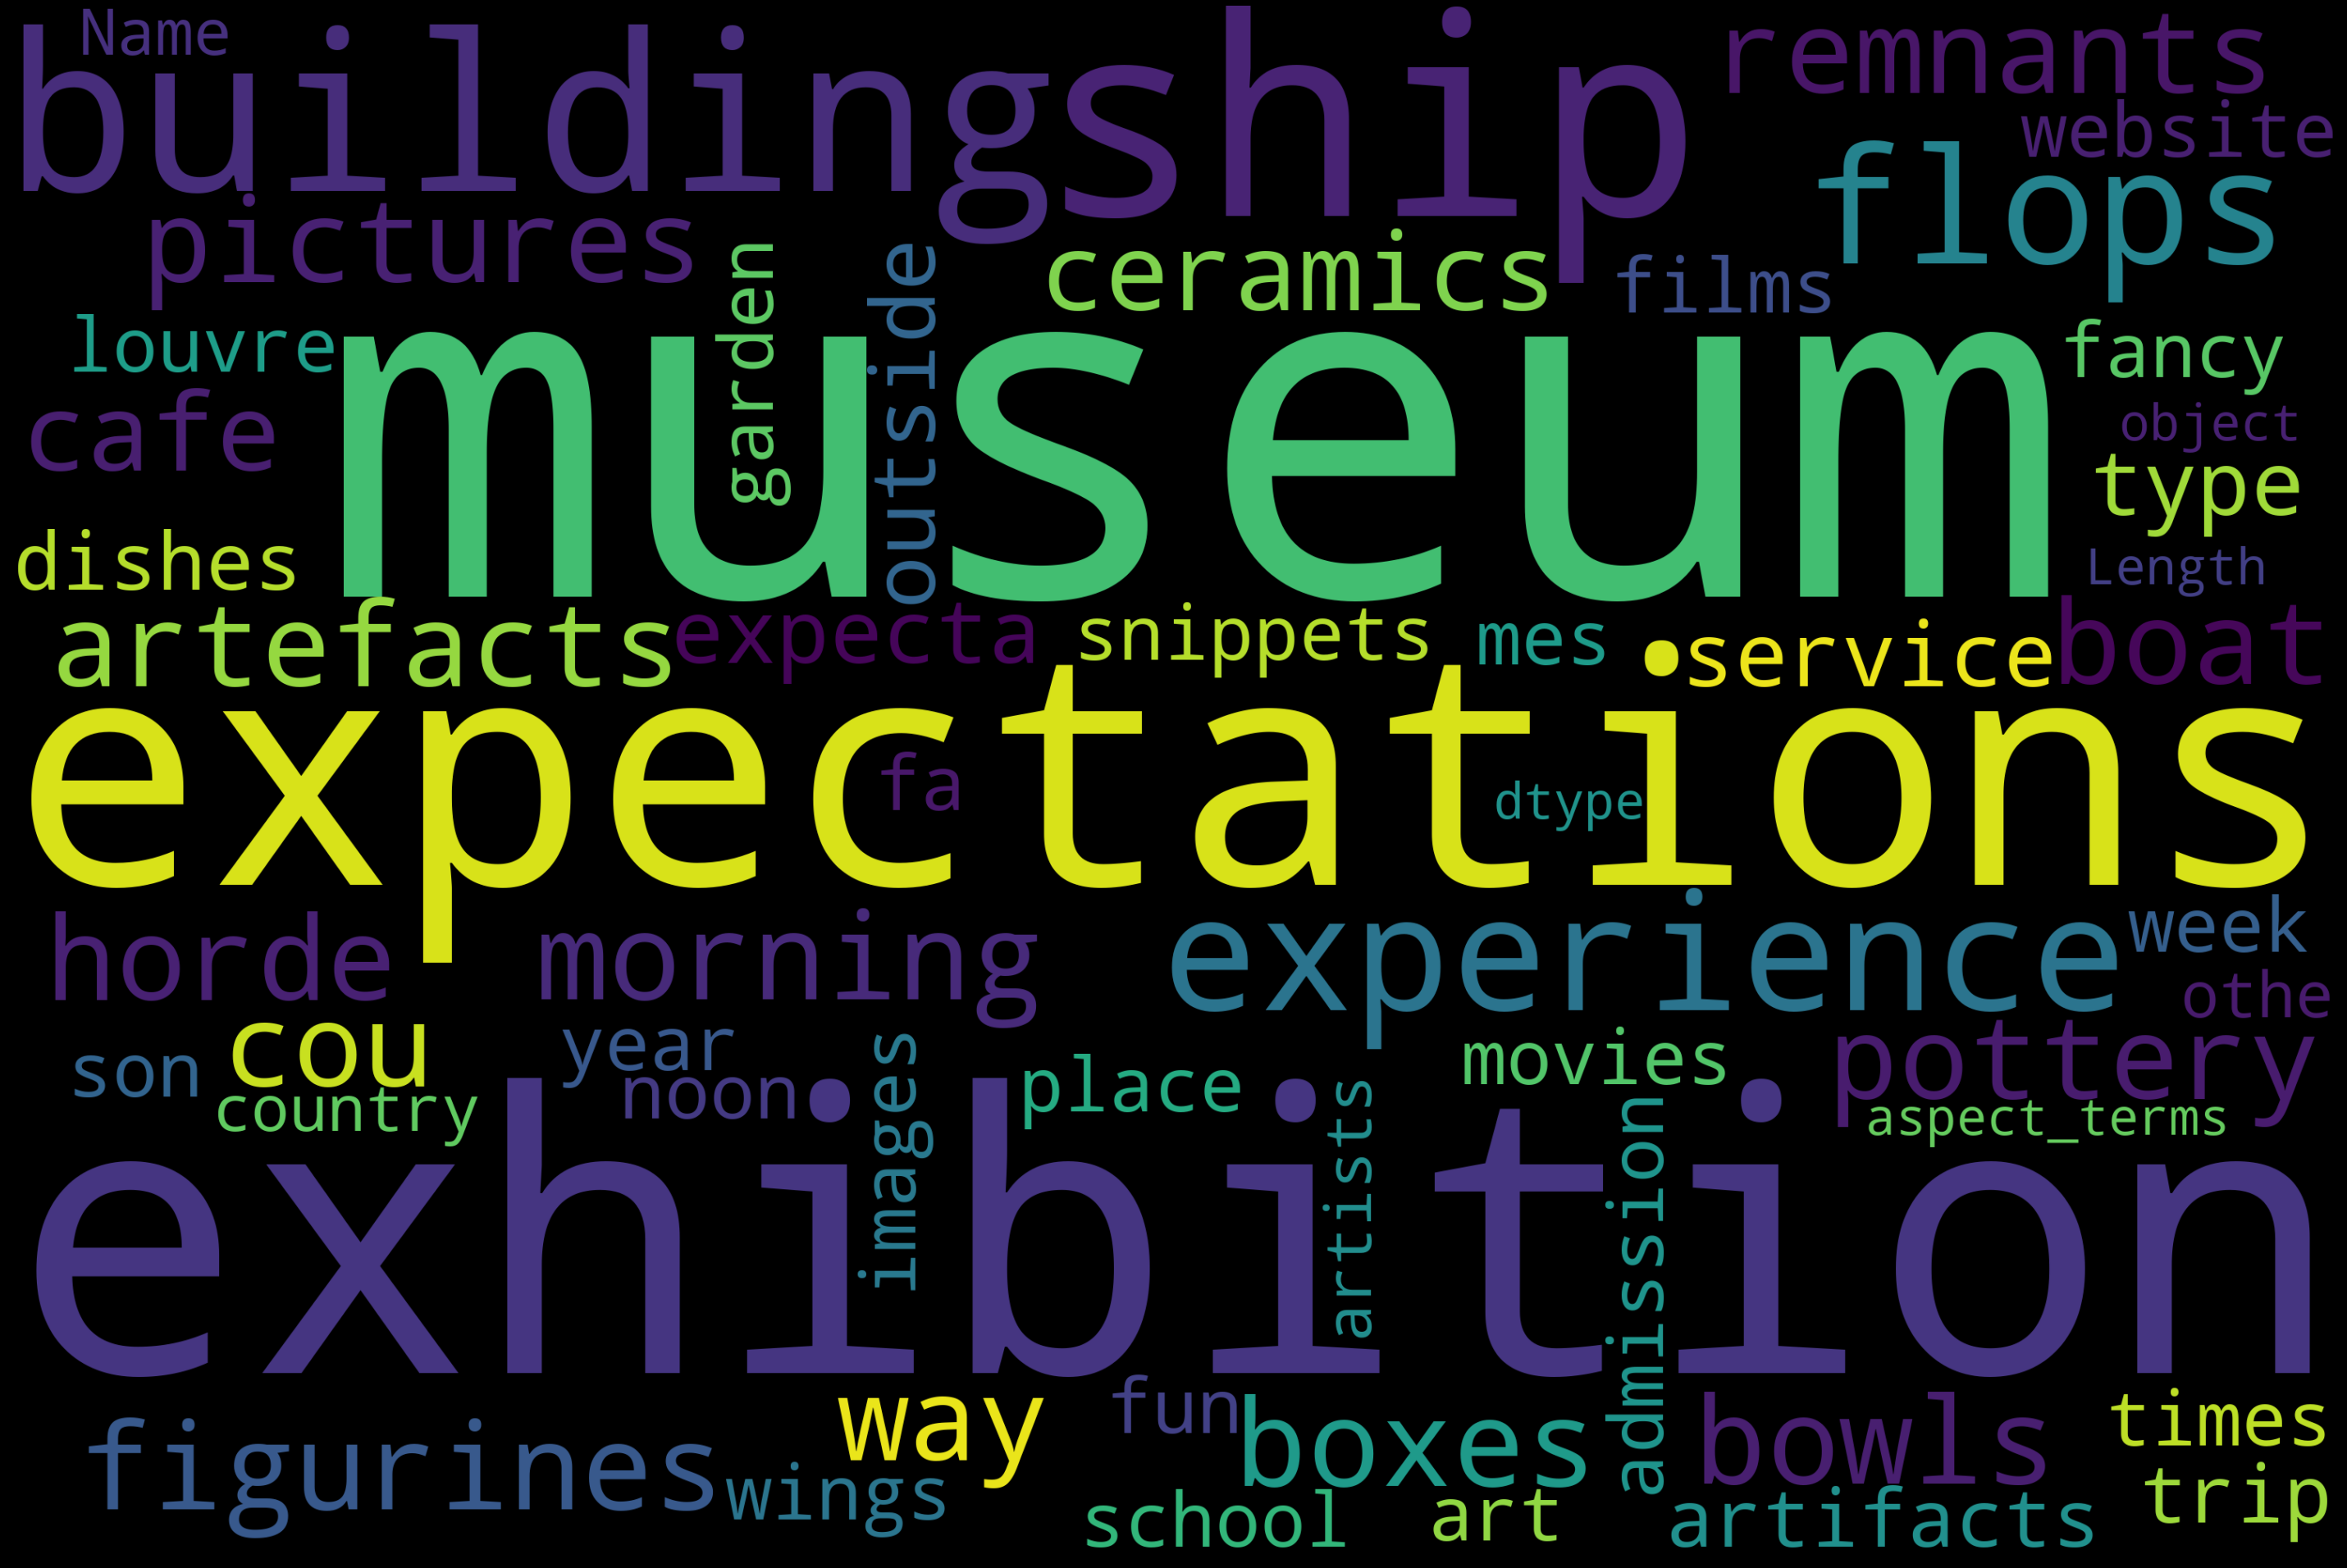

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = ok_terms
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

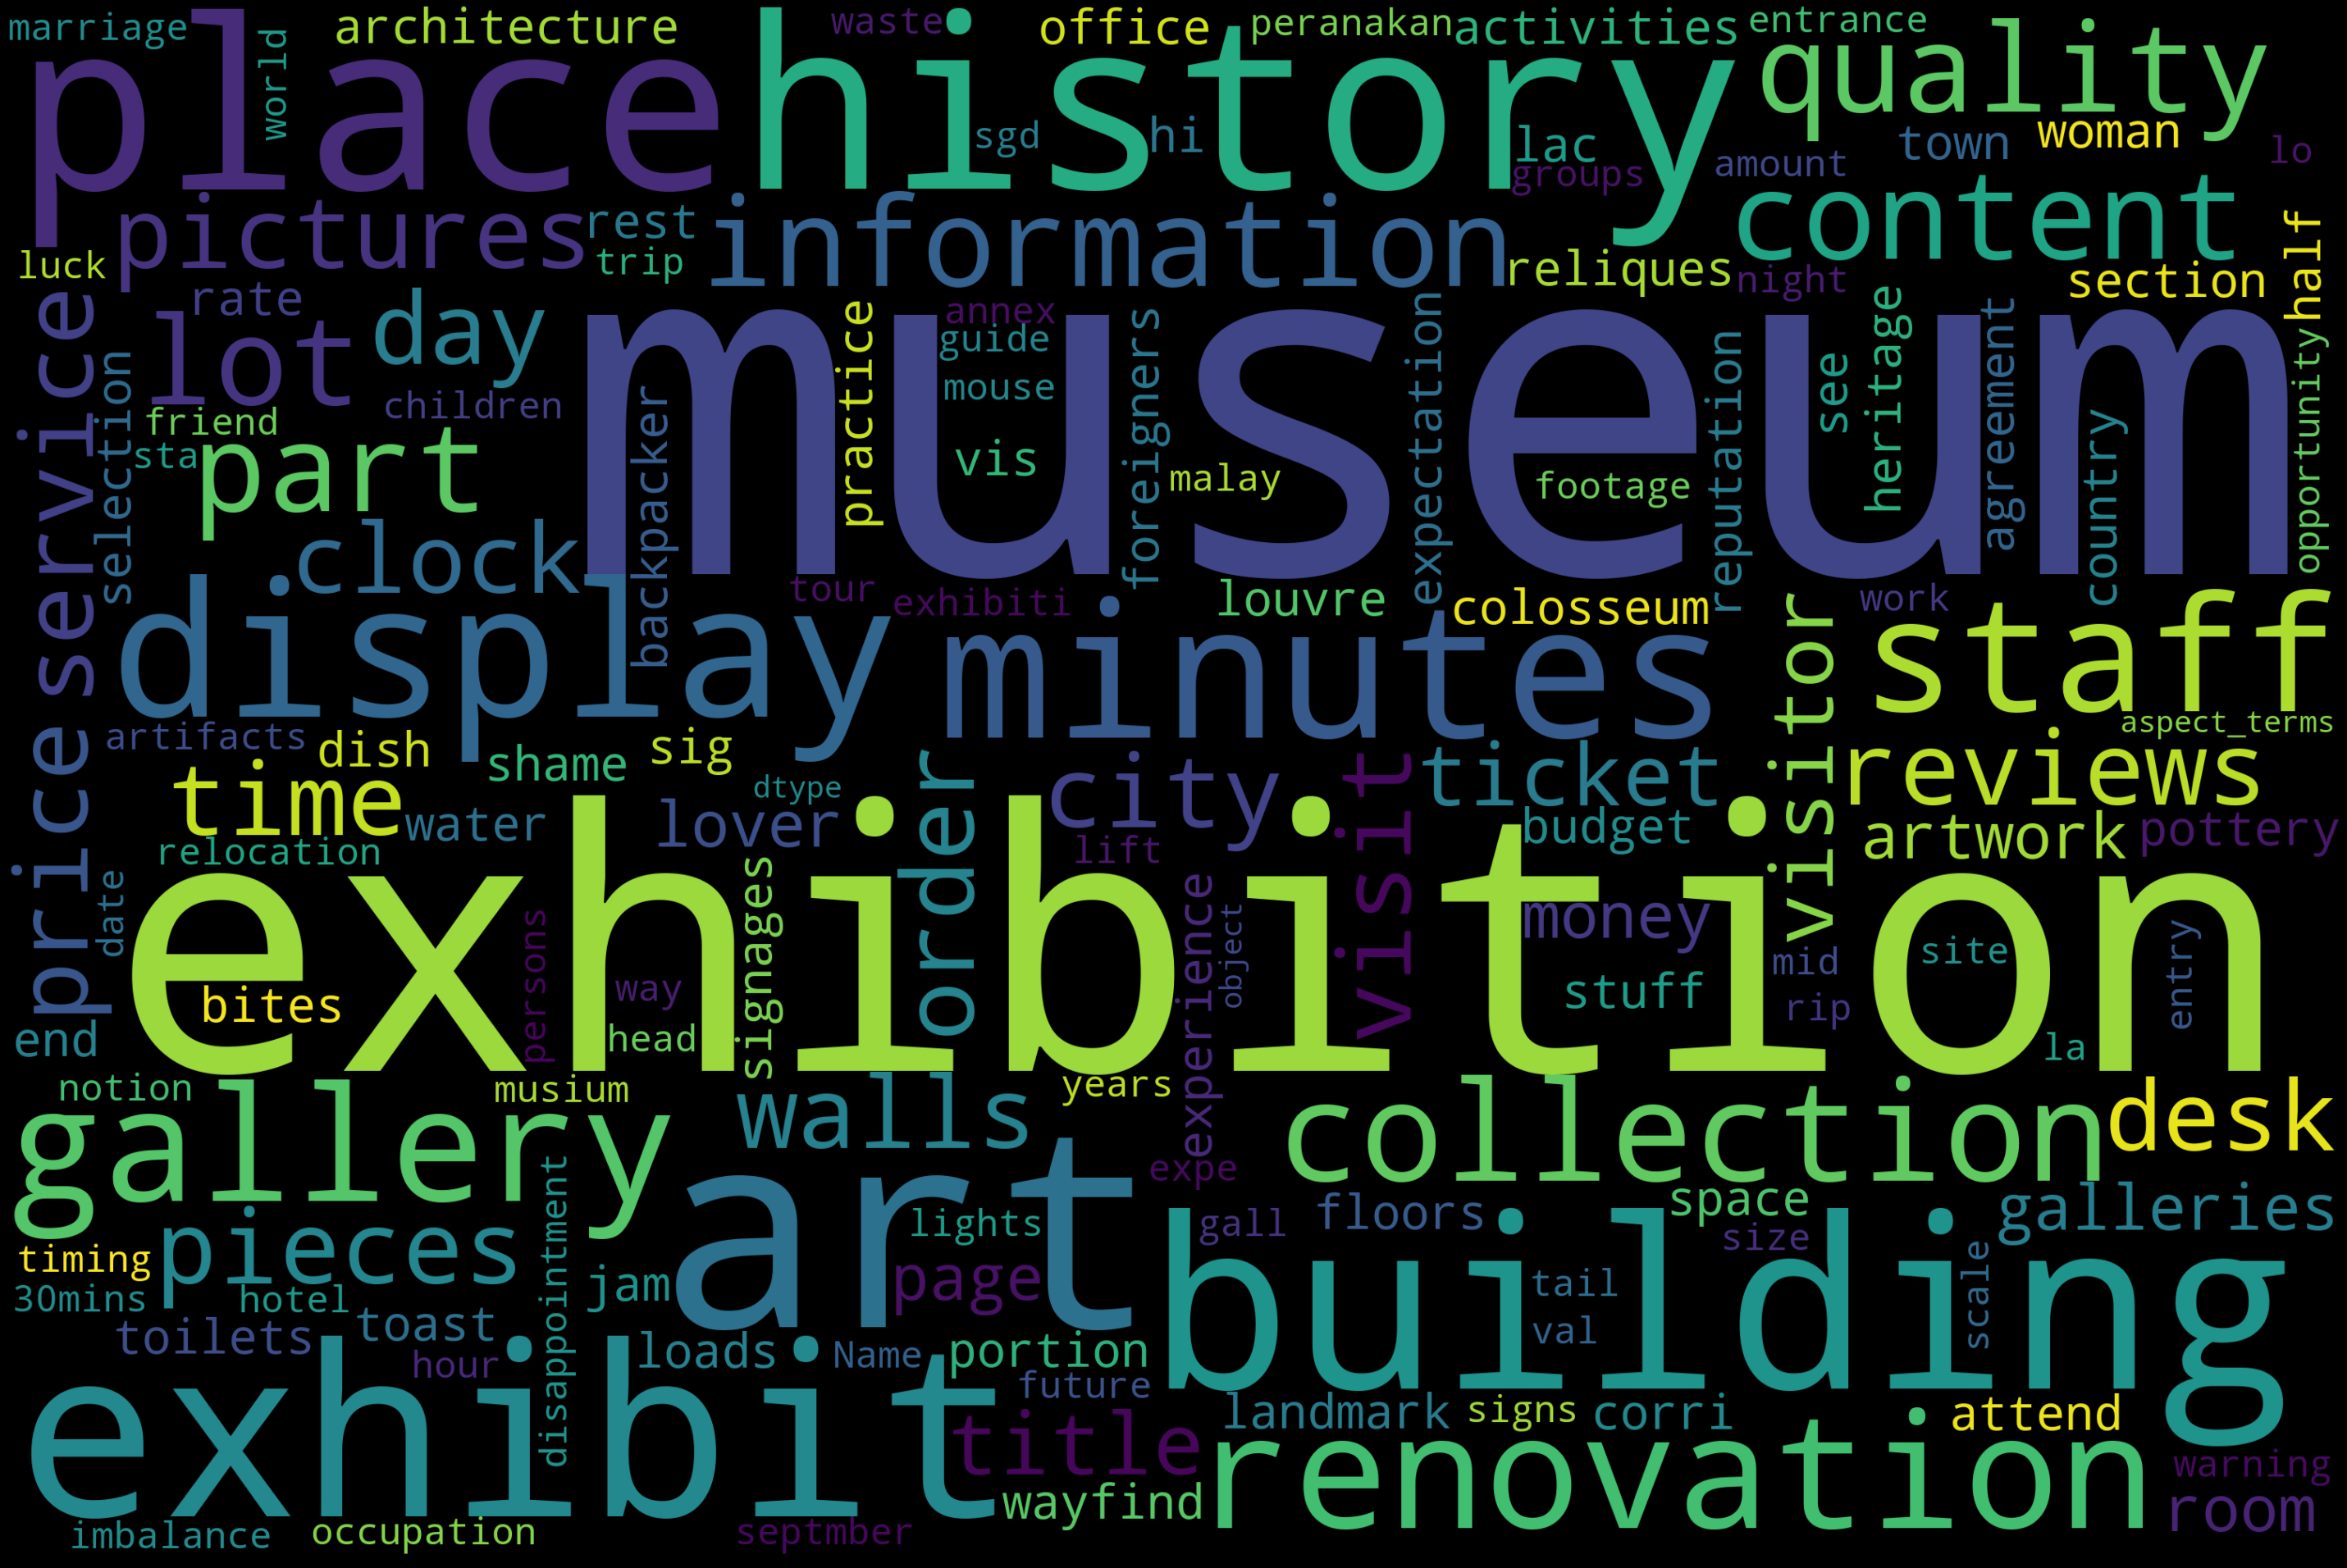

In [51]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = bad_terms
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

# Obtaining the Good/Ok/Bad Aspects

## create respective dict and do processing to obtain most relevant list of words and see what insights we can get

In [103]:
print(good_terms)
print(good_sentiments)

1                                                                                                                                                                                                                                                                                place exhibitions photos people photos
2                                                                                                                                                                                                                                                                         exhibit finds shipwreck highlight trip friend
3                                                                                                                                            art culture building presence exhibit cargo ship overview porcelain ceramics house statues idols worship place place galleries citizens residents minimum hours facilities
4                                                               

In [106]:
good_tokens = [string.split() for string in good_terms]
good_sentiments = [string.split() for string in good_sentiments]

good_dict = gensim.corpora.Dictionary(good_tokens)
good_sentiments_dict = gensim.corpora.Dictionary(good_sentiments)

In [95]:
# Create a dictionary representation of the documents.
print("Number of Good Vocabulary before filtering:", len(good_dict))
# Filter out words that occur less than 5 documents
good_dict.filter_extremes(no_below=5)
print("\nFiltered Number of Vocabulary:", len(good_dict))

Number of Good Vocabulary before filtering: 4613

Filtered Number of Vocabulary: 1073


In [107]:
good_corpus = [good_dict.doc2bow(doc) for doc in good_tokens]
good_sentiment_corpus = [good_sentiments_dict.doc2bow(doc) for doc in good_sentiments]

In [108]:
good_sentiments_docs_freq = [good_sentiments_dict[id] for doc in good_sentiment_corpus for id, frequency in doc]
#print(docs_freq)
good_sentiment_fdist = FreqDist(good_sentiments_docs_freq)
good_sentiment_fdist.most_common(20)

[('visit', 939),
 ('good', 879),
 ('great', 804),
 ('interesting', 800),
 ('worth', 639),
 ('spend', 592),
 ('free', 534),
 ('beautiful', 500),
 ('enjoy', 478),
 ('learn', 475),
 ('old', 401),
 ('go', 393),
 ('asian', 371),
 ('nice', 354),
 ('recommend', 350),
 ('excellent', 348),
 ('find', 347),
 ('guide', 336),
 ('love', 315),
 ('take', 293)]

In [97]:
good_docs_freq = [good_dict[id] for doc in good_corpus for id, frequency in doc]
#print(docs_freq)
good_fdist = FreqDist(good_docs_freq)
good_fdist.most_common(20)

[('museum', 1644),
 ('history', 1178),
 ('building', 763),
 ('exhibits', 681),
 ('place', 678),
 ('time', 586),
 ('hours', 536),
 ('gallery', 474),
 ('tour', 469),
 ('visit', 462),
 ('art', 458),
 ('exhibition', 442),
 ('culture', 435),
 ('collection', 361),
 ('exhibitions', 320),
 ('museums', 296),
 ('displays', 293),
 ('way', 285),
 ('day', 285),
 ('galleries', 271)]

In [98]:
#remove domain specific stopwords and try and identify unique aspects that made them define a "good" visit 
print("Length of Good_Dictionary:", len(good_dict))
good_dict.filter_tokens(bad_ids=[good_dict.token2id['museum'],
                                  good_dict.token2id['building'],
                                  good_dict.token2id['place'],
                                  good_dict.token2id['gallery'],
                                  good_dict.token2id['visit'],
                                  good_dict.token2id['exhibition'],
                                  good_dict.token2id['exhibitions'],
                                  good_dict.token2id['museums'],
                                  good_dict.token2id['displays'],
                                  good_dict.token2id['way'],
                                  good_dict.token2id['galleries'],
                                  good_dict.token2id['lot'],
                                  good_dict.token2id['buildings'],
                                  good_dict.token2id['exhibits'],
                                  good_dict.token2id['exhibit'],
                                  good_dict.token2id['display'],
                                  good_dict.token2id['floor'],
                                  good_dict.token2id['part'],
                                 good_dict.token2id['time'],
                                 good_dict.token2id['hours'],
                                 good_dict.token2id['art'],
                                 good_dict.token2id['day'],
                                 good_dict.token2id['life'],
                                 good_dict.token2id['pieces']
                                 
                                 
                                 

                                     ])
print("Length of Dictionary after removing additional stopwords:", len(good_dict))

Length of Good_Dictionary: 1073
Length of Dictionary after removing additional stopwords: 1049


In [99]:
good_corpus = [good_dict.doc2bow(doc) for doc in good_tokens]

In [100]:
good_docs_freq = [good_dict[id] for doc in good_corpus for id, frequency in doc]
#print(docs_freq)
good_fdist = FreqDist(good_docs_freq)
good_fdist.most_common(20)

[('history', 1178),
 ('tour', 469),
 ('culture', 435),
 ('collection', 361),
 ('people', 258),
 ('guide', 220),
 ('staff', 219),
 ('information', 217),
 ('artifacts', 197),
 ('experience', 183),
 ('cultures', 180),
 ('children', 179),
 ('architecture', 177),
 ('tours', 167),
 ('lots', 162),
 ('shop', 154),
 ('kids', 154),
 ('area', 152),
 ('fee', 144),
 ('story', 142)]

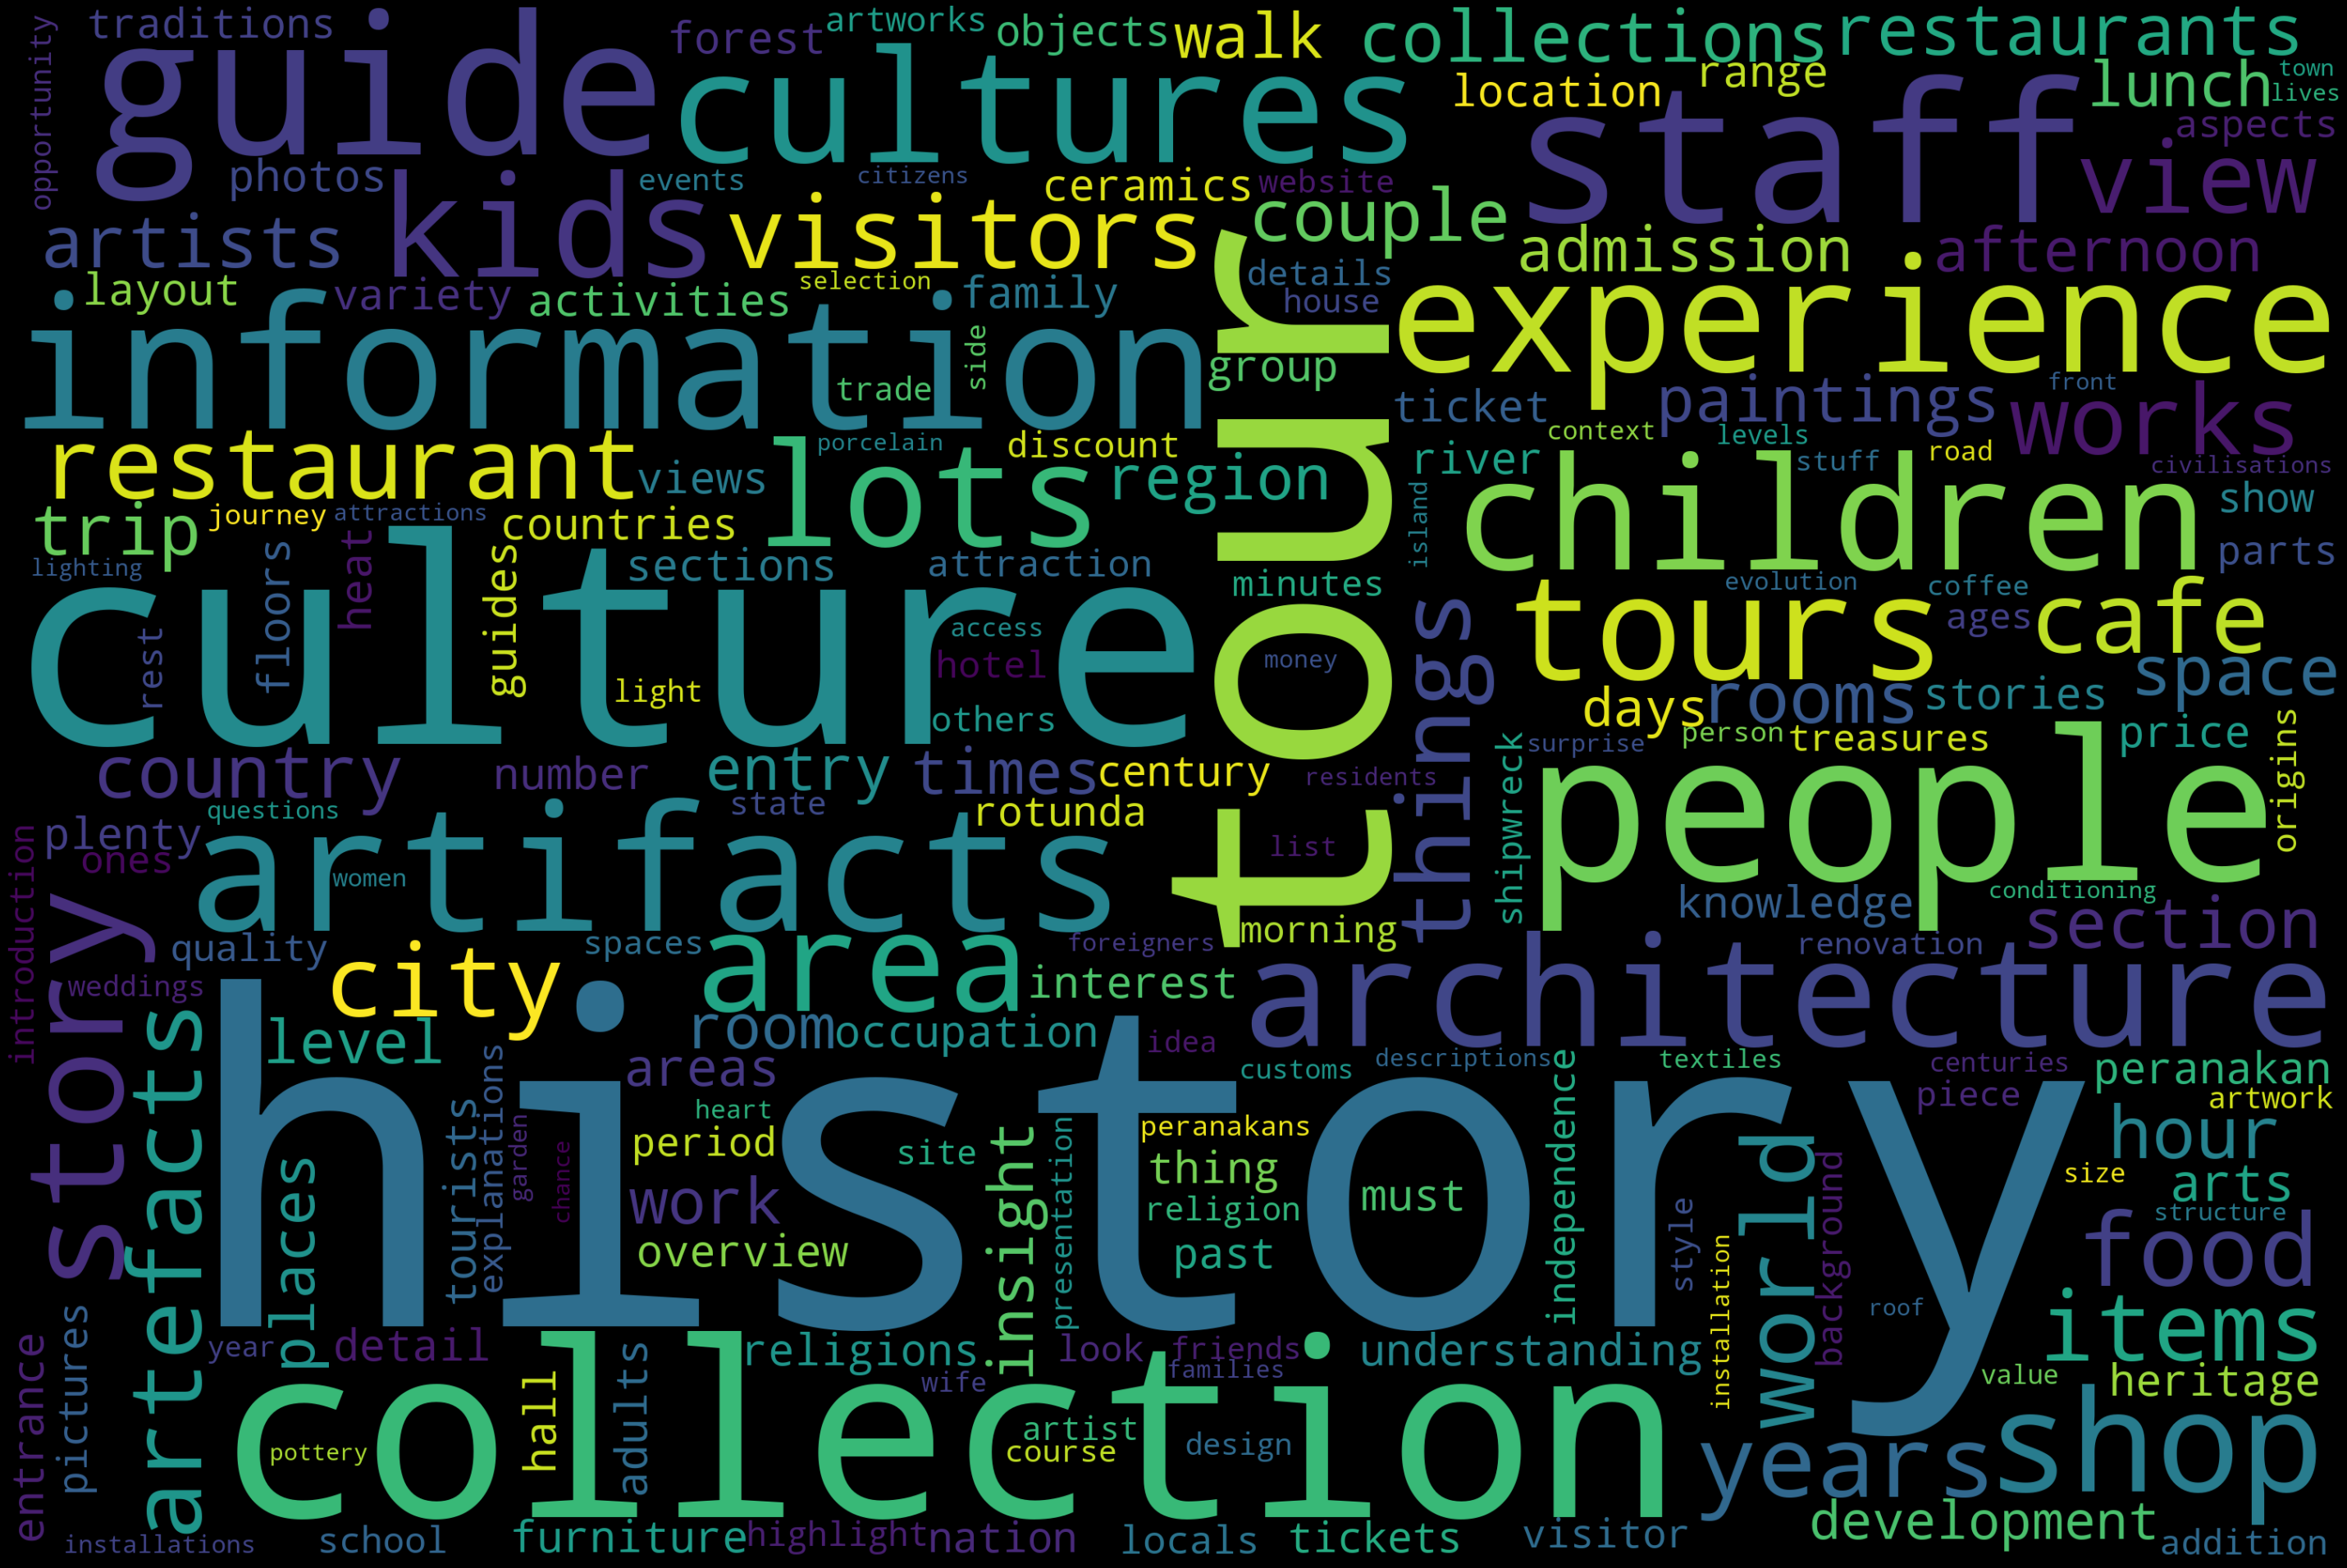

In [101]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


filter_words = dict([(m, n) for m, n in good_fdist.items() if len(m) > 3])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate_from_frequencies(filter_words)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

In [61]:
ok_tokens = [string.split() for string in ok_terms]

ok_dict = gensim.corpora.Dictionary(ok_tokens)

In [62]:
# Create a dictionary representation of the documents.
print("Number of Ok Vocabulary before filtering:", len(ok_dict))
# Filter out words that occur less than 5 documents
ok_dict.filter_extremes(no_below=5)
print("\nFiltered Number of Vocabulary:", len(ok_dict))

Number of Ok Vocabulary before filtering: 2977

Filtered Number of Vocabulary: 609


In [63]:
ok_corpus = [ok_dict.doc2bow(doc) for doc in ok_tokens]

In [64]:
ok_docs_freq = [ok_dict[id] for doc in ok_corpus for id, frequency in doc]
#print(docs_freq)
ok_fdist = FreqDist(ok_docs_freq)
ok_fdist.most_common(20)

[('museum', 818),
 ('history', 570),
 ('exhibits', 372),
 ('building', 359),
 ('place', 308),
 ('time', 259),
 ('culture', 204),
 ('hours', 200),
 ('visit', 199),
 ('art', 195),
 ('exhibition', 192),
 ('gallery', 192),
 ('lot', 145),
 ('galleries', 138),
 ('collection', 133),
 ('tour', 130),
 ('displays', 130),
 ('exhibitions', 128),
 ('display', 120),
 ('people', 120)]

In [65]:
#remove domain specific stopwords
print("Length of Ok_Dictionary:", len(ok_dict))
ok_dict.filter_tokens(bad_ids=[ok_dict.token2id['museum'],
                               ok_dict.token2id['exhibits'],
                               ok_dict.token2id['building'],
                               ok_dict.token2id['place'],
                               ok_dict.token2id['visit'],
                               ok_dict.token2id['lot'],
                               ok_dict.token2id['galleries'],
                               


                                     ])
print("Length of Dictionary after removing additional stopwords:", len(ok_dict))

Length of Ok_Dictionary: 609
Length of Dictionary after removing additional stopwords: 602


In [66]:
ok_corpus = [ok_dict.doc2bow(doc) for doc in ok_tokens]

In [67]:
ok_docs_freq = [ok_dict[id] for doc in ok_corpus for id, frequency in doc]
#print(docs_freq)
ok_fdist = FreqDist(ok_docs_freq)
ok_fdist.most_common(20)

[('history', 570),
 ('time', 259),
 ('culture', 204),
 ('hours', 200),
 ('art', 195),
 ('exhibition', 192),
 ('gallery', 192),
 ('collection', 133),
 ('tour', 130),
 ('displays', 130),
 ('exhibitions', 128),
 ('display', 120),
 ('people', 120),
 ('museums', 119),
 ('way', 115),
 ('day', 102),
 ('children', 101),
 ('things', 100),
 ('staff', 96),
 ('exhibit', 95)]

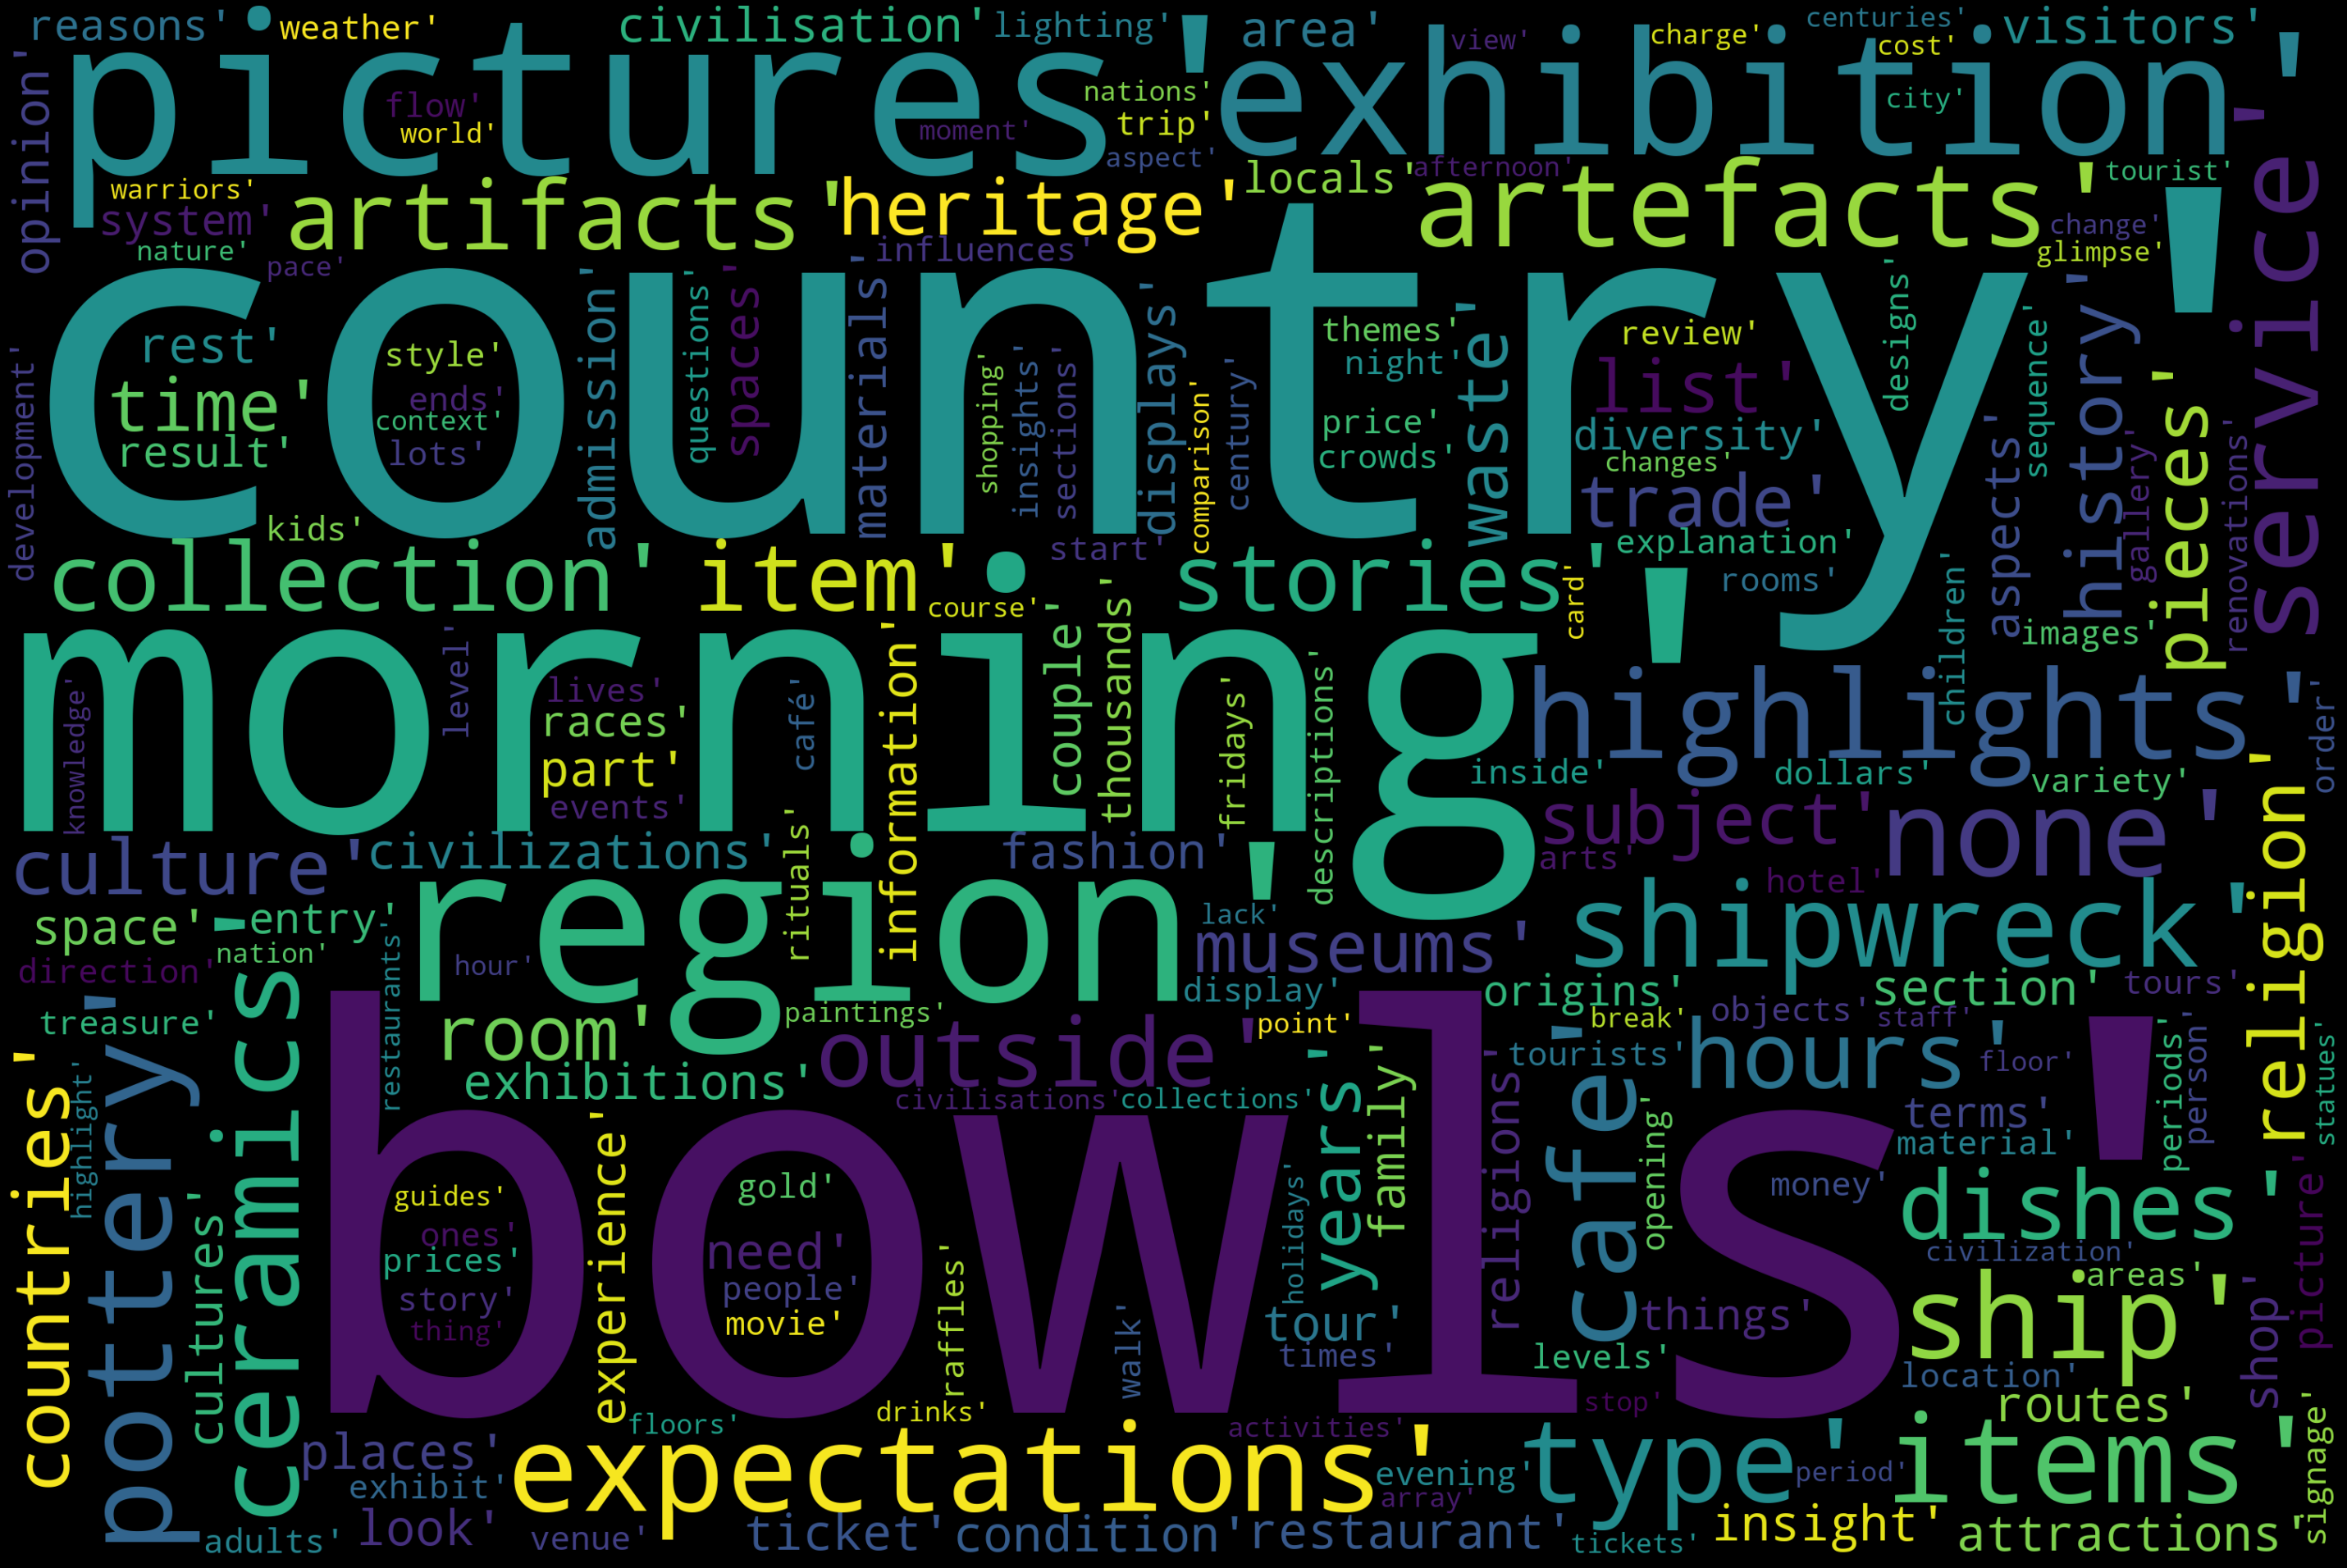

In [68]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


filter_words = dict([(m, n) for m, n in ok_fdist.items() if len(m) > 3])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(filter_words))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

In [69]:
bad_tokens = [string.split() for string in bad_terms]

bad_dict = gensim.corpora.Dictionary(bad_tokens)

In [70]:
# Create a dictionary representation of the documents.
print("Number of Bad Vocabulary before filtering:", len(bad_dict))
# Filter out words that occur less than 5 documents
bad_dict.filter_extremes(no_below=2)
print("\nFiltered Number of Vocabulary:", len(bad_dict))

Number of Bad Vocabulary before filtering: 273

Filtered Number of Vocabulary: 62


In [71]:
bad_corpus = [bad_dict.doc2bow(doc) for doc in bad_tokens]

In [72]:
bad_docs_freq = [bad_dict[id] for doc in bad_corpus for id, frequency in doc]
#print(docs_freq)
bad_fdist = FreqDist(bad_docs_freq)
bad_fdist.most_common(20)

[('museum', 17),
 ('exhibition', 10),
 ('art', 9),
 ('history', 9),
 ('exhibits', 8),
 ('exhibitions', 7),
 ('display', 5),
 ('minutes', 5),
 ('building', 5),
 ('staff', 5),
 ('place', 5),
 ('museums', 4),
 ('pictures', 4),
 ('gallery', 4),
 ('galleries', 4),
 ('children', 4),
 ('collection', 3),
 ('pieces', 3),
 ('information', 3),
 ('visitors', 3)]

In [73]:
# #remove domain specific stopwords
# print("Length of Bad_Dictionary:", len(ok_dict))
# ok_dict.filter_tokens(bad_ids=[ok_dict.token2id['museum'],
#                                ok_dict.token2id['exhibits'],
#                                ok_dict.token2id['building'],
#                                ok_dict.token2id['place'],
#                                ok_dict.token2id['visit'],
#                                ok_dict.token2id['lot'],
#                                ok_dict.token2id['galleries'],
                               


#                                      ])
# print("Length of Dictionary after removing additional stopwords:", len(ok_dict))

In [74]:
bad_corpus = [bad_dict.doc2bow(doc) for doc in bad_tokens]

In [75]:
bad_docs_freq = [bad_dict[id] for doc in bad_corpus for id, frequency in doc]
#print(docs_freq)
bad_fdist = FreqDist(bad_docs_freq)
bad_fdist.most_common(20)

[('museum', 17),
 ('exhibition', 10),
 ('art', 9),
 ('history', 9),
 ('exhibits', 8),
 ('exhibitions', 7),
 ('display', 5),
 ('minutes', 5),
 ('building', 5),
 ('staff', 5),
 ('place', 5),
 ('museums', 4),
 ('pictures', 4),
 ('gallery', 4),
 ('galleries', 4),
 ('children', 4),
 ('collection', 3),
 ('pieces', 3),
 ('information', 3),
 ('visitors', 3)]

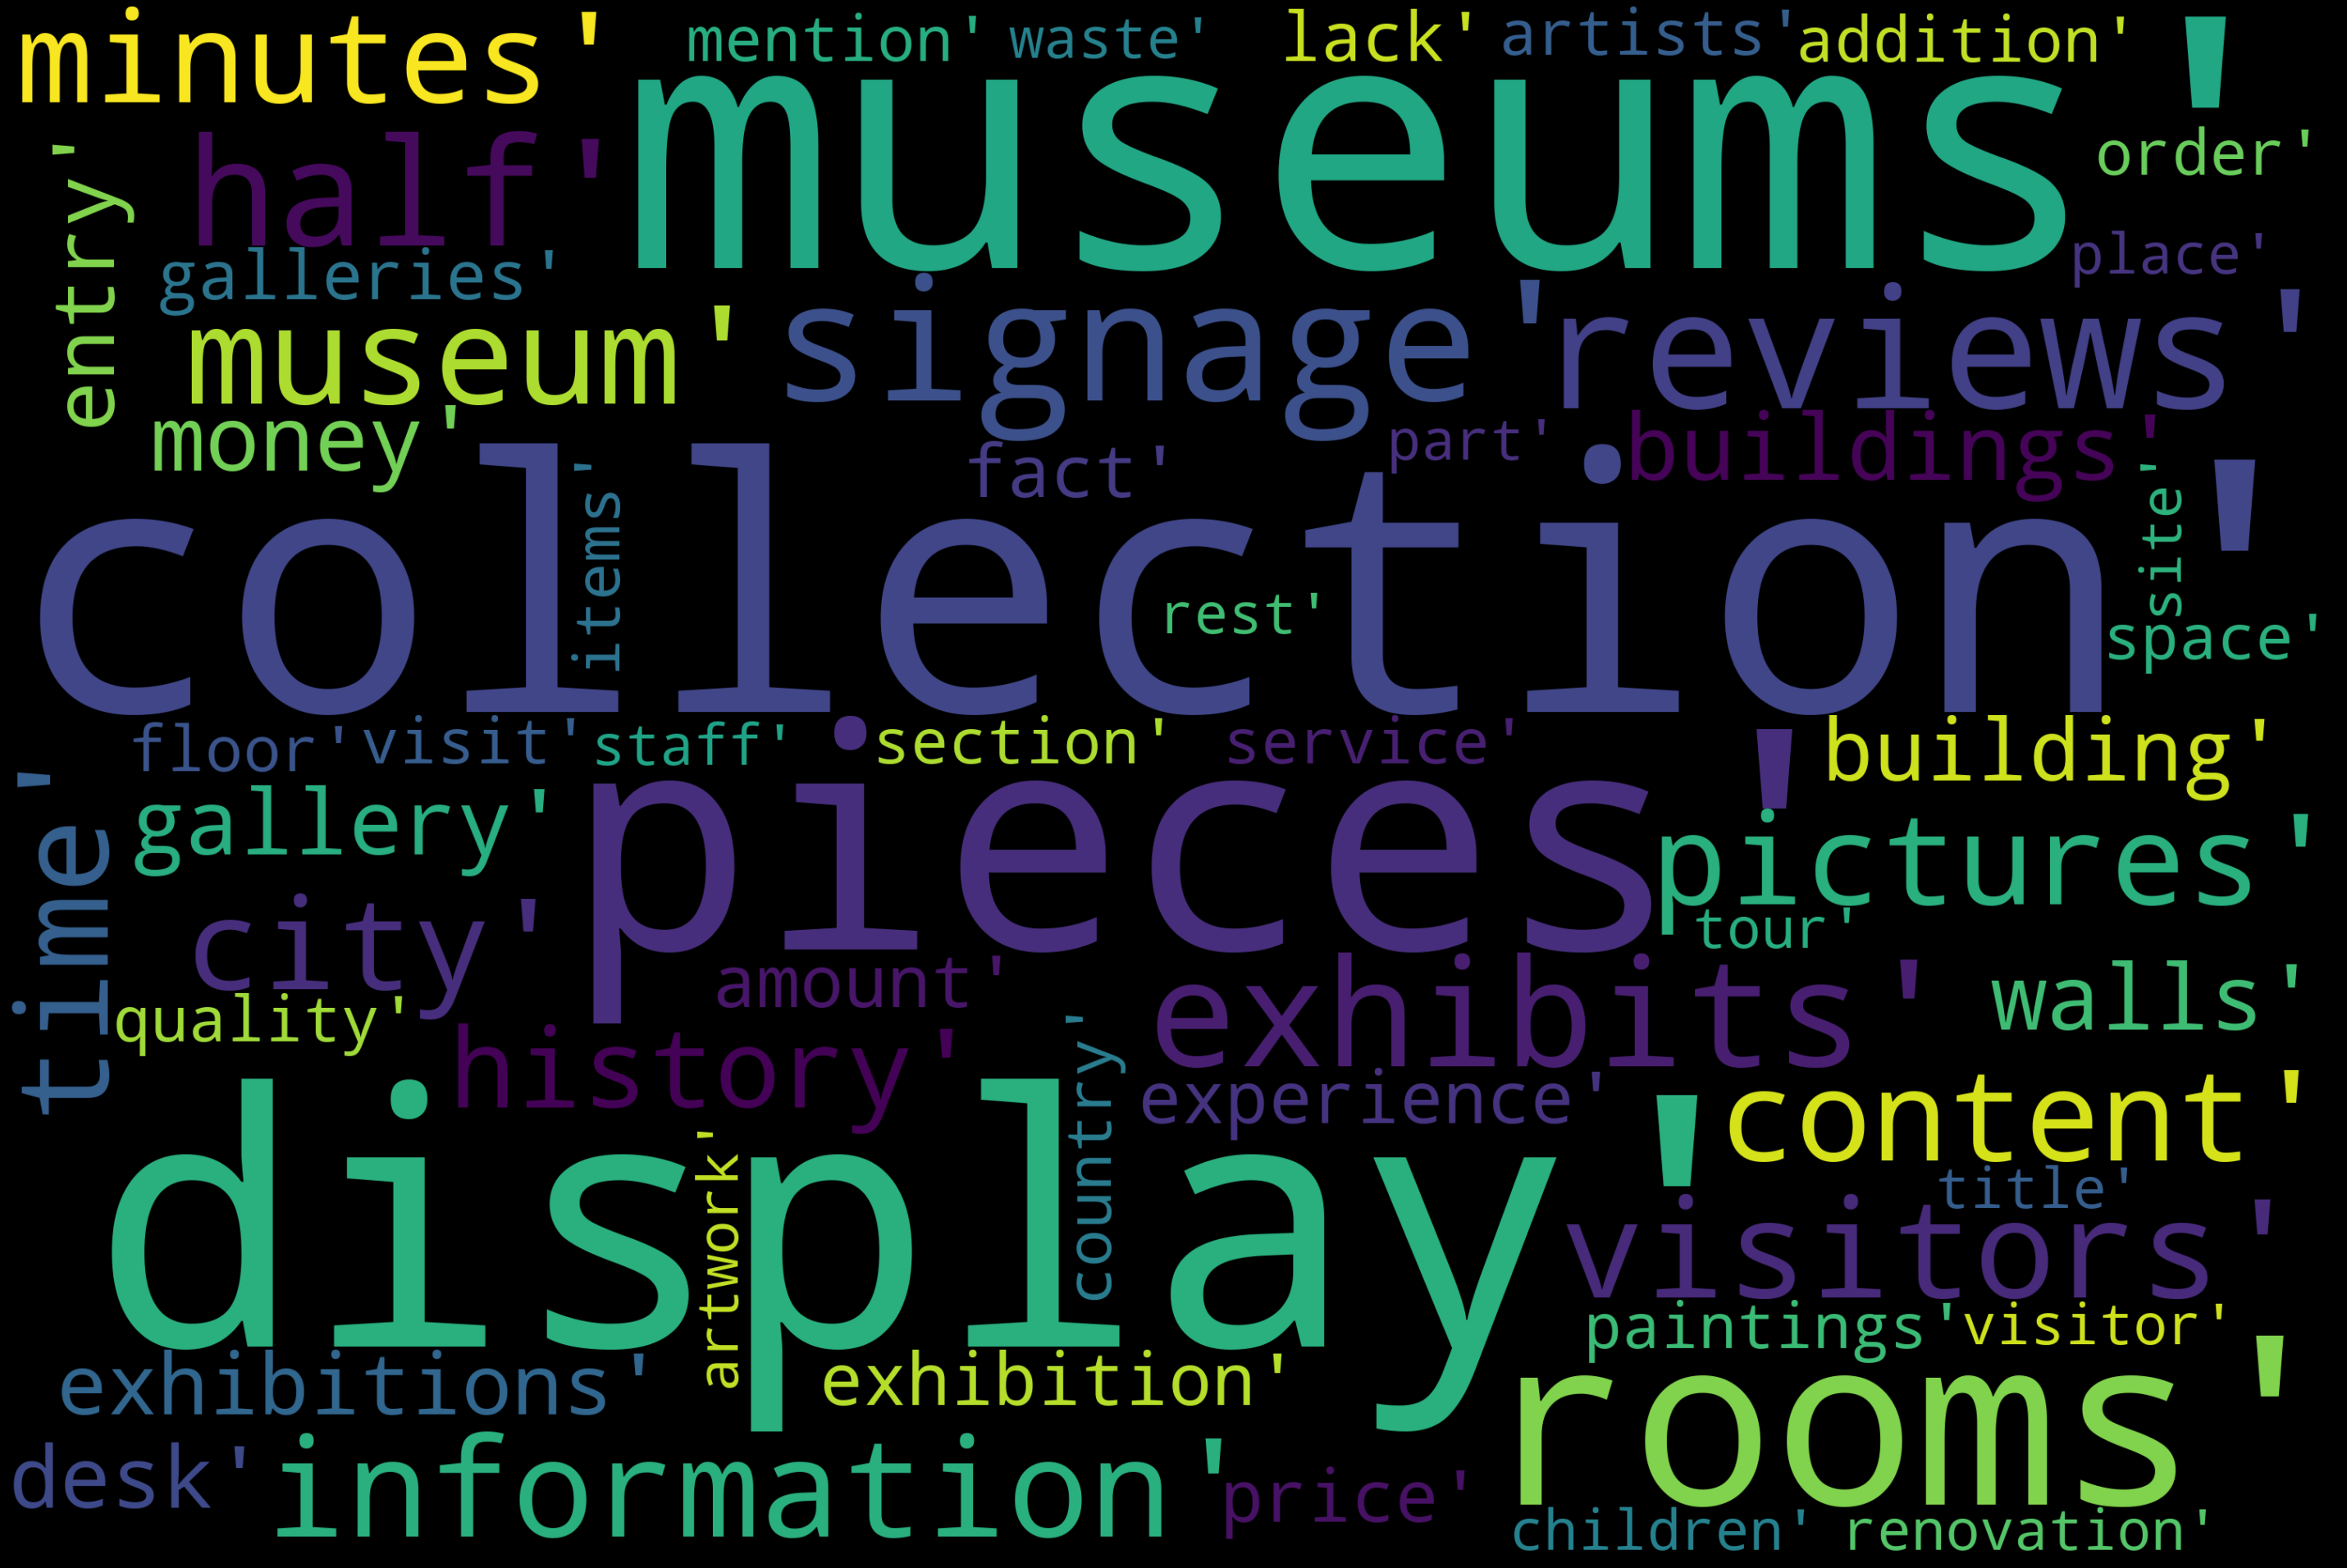

In [76]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


filter_words = dict([(m, n) for m, n in bad_fdist.items() if len(m) > 3])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(filter_words))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()